# Training Using RobustScalat for Normalization


### Library Import & Initial Setup

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from math import sqrt, atan2
from scipy.signal import savgol_filter
from hampel import hampel
from sklearn.preprocessing import RobustScaler
from collections import defaultdict


### Load DataSet CIS Raw

In [2]:
# Path ke dataset RX_1
main_folder_path_rx1 = os.path.join('..', '..', 'data', 'raw', 'dataset_scene2', 'dataset RX 1')


# Inisialisasi struktur data untuk menyimpan hasil
activity_dataframes_rx1 = []
label_list_rx1 = []
label_row_counts_rx1 = defaultdict(int)

# Iterasi melalui setiap subfolder dalam RX_1
for activity_folder in os.listdir(main_folder_path_rx1):
    activity_folder_path = os.path.join(main_folder_path_rx1, activity_folder)
    
    if os.path.isdir(activity_folder_path):  # Pastikan ini folder
        for file_name in os.listdir(activity_folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(activity_folder_path, file_name)
                
                # Tambahkan label aktivitas
                label_list_rx1.append(activity_folder)
                
                # Baca file CSV ke DataFrame
                df = pd.read_csv(file_path)
                activity_dataframes_rx1.append(df)

                # Hitung jumlah baris per label
                label_row_counts_rx1[activity_folder] += len(df)

print("Data RX_1 telah dimuat.")

Data RX_1 telah dimuat.


In [3]:
# Path ke dataset RX_2
main_folder_path_rx2 = os.path.join('..', '..', 'data', 'raw', 'dataset_scene2', 'dataset RX 2')


# Inisialisasi struktur data untuk menyimpan hasil
activity_dataframes_rx2 = []
label_list_rx2 = []
label_row_counts_rx2 = defaultdict(int)

# Iterasi melalui setiap subfolder dalam RX_2
for activity_folder in os.listdir(main_folder_path_rx2):
    activity_folder_path = os.path.join(main_folder_path_rx2, activity_folder)
    
    if os.path.isdir(activity_folder_path):  # Pastikan ini folder
        for file_name in os.listdir(activity_folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(activity_folder_path, file_name)
                
                # Tambahkan label aktivitas
                label_list_rx2.append(activity_folder)
                
                # Baca file CSV ke DataFrame
                df = pd.read_csv(file_path)
                activity_dataframes_rx2.append(df)

                # Hitung jumlah baris per label
                label_row_counts_rx2[activity_folder] += len(df)

print("Data RX_2 telah dimuat.")


Data RX_2 telah dimuat.


### Membuat fungsi untuk visualisasi

In [4]:
def plot_bar_chart(dd_counts, jl_counts, bd_counts):
    # Labels
    labels = ['dd', 'jl', 'bd']
    
    # Values
    dd_values = [dd_counts.get(str(i), 0) for i in range(3)]
    jl_values = [jl_counts.get(str(i), 0) for i in range(3)]
    bd_values = [bd_counts.get(str(i), 0) for i in range(3)]
    
    x = range(len(dd_values))
    width = 0.2

    fig, ax = plt.subplots()
    ax.bar([i - width for i in x], dd_values, width, label='DD')
    ax.bar(x, jl_values, width, label='JL')
    ax.bar([i + width for i in x], bd_values, width, label='BD')

    ax.set_ylabel('Jumlah Data')
    ax.set_title('Jumlah Data berdasarkan Label')
    ax.set_xticks(x)
    ax.set_xticklabels(['0', '1', '2'])
    ax.legend()

    plt.show()

In [5]:
def plot_data(df, numeric,max_cols):
    """
    Plots the numeric columns of the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame to plot
    numeric (list): List of numeric column names to plot
    """
    # max_cols = 20  # Set maximum columns to plot
    cols_to_plot = numeric[:max_cols]  # Take only the first 10 columns

    plt.figure(figsize=(35, 15))  # Adjusted figure size for better visualization
    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot(len(cols_to_plot), 1, i)
        sns.boxplot(data=df, x=col)
        plt.title(f'Title: {col}')
    plt.tight_layout()
    plt.show()

In [6]:
def plot_boxplots(df,titel):
    """
    Plots boxplots for all numeric columns in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing numeric data to plot
    """
    plt.figure(figsize=(20, 10))  # Adjust figure size as needed

    all_data = []

    for col in df.columns:
        data = pd.to_numeric(df[col], errors='coerce').dropna().values
        all_data.append(data)

    plt.boxplot(all_data, labels=df.columns)
    plt.xlabel('Subcarier')
    plt.ylabel('Amplitude')
    # plt.title(titel)
    plt.xticks(rotation=45)  # Rotate x-axis labels if necessary for readability

    plt.show()

## Exploratory Data Analysis (EDA)

## total row

### RX1

In [7]:
total_rx1 = 0

# Menampilkan jumlah baris untuk setiap label di RX_1
print("Jumlah Dataset pada RX_1:")
for label, total_rows in label_row_counts_rx1.items():
    print(f'{label} : {total_rows} rows')
    total_rx1 += total_rows

print('Total :', total_rx1)


Jumlah Dataset pada RX_1:
BD : 42336 rows
DD : 43427 rows
JL : 43052 rows
Total : 128815


### RX2

In [8]:
total_rx2 = 0

# Menampilkan jumlah baris untuk setiap label di RX_2
print("Jumlah Dataset pada RX_2:")
for label, total_rows in label_row_counts_rx2.items():
    print(f'{label} : {total_rows} rows')
    total_rx2 += total_rows

print('Total :', total_rx2)


Jumlah Dataset pada RX_2:
BD : 40871 rows
DD : 43712 rows
JL : 43224 rows
Total : 127807


## Statistik Deskriptif

In [9]:
print(activity_dataframes_rx2[0].dtypes)

type                  object
role                  object
mac                   object
rssi                   int64
rate                   int64
sig_mode               int64
mcs                    int64
bandwidth              int64
smoothing              int64
not_sounding           int64
aggregation            int64
stbc                   int64
fec_coding             int64
sgi                    int64
noise_floor            int64
ampdu_cnt              int64
channel                int64
secondary_channel      int64
local_timestamp        int64
ant                    int64
sig_len                int64
rx_state               int64
real_time_set          int64
real_timestamp       float64
len                    int64
CSI_DATA              object
dtype: object


In [10]:
print(activity_dataframes_rx2[0]['CSI_DATA'].head())

0    [-125 48 8 0 0 0 0 0 0 0 0 0 -34 -2 -34 -4 -34...
1    [-121 112 8 0 0 0 0 0 0 0 0 0 -26 22 -28 19 -2...
2    [-17 -16 14 0 0 0 0 0 0 0 0 0 -21 26 -22 23 -2...
3    [37 80 2 0 0 0 0 0 0 0 0 0 -36 -3 -35 -3 -36 -...
4    [82 -96 4 0 0 0 0 0 0 0 0 0 1 29 -1 26 -1 28 -...
Name: CSI_DATA, dtype: object


### RX1

In [11]:
activity_dataframes_rx1[0].describe()  # Menampilkan statistik deskriptif dari file pertama RX 1


,rssi,rate,sig_mode,mcs,bandwidth,smoothing,not_sounding,aggregation,stbc,fec_coding,...,ampdu_cnt,channel,secondary_channel,local_timestamp,ant,sig_len,rx_state,real_time_set,real_timestamp,len
count,3238.000000,3238.0,3238.000000,3238.000000,3238.000000,3238.000000,3238.000000,3238.00000,3238.0,3238.0,...,3238.000000,3238.0,3238.0,3.238000e+03,3238.0,3238.000000,3238.0,3238.0,3238.000000,3238.000000
mean,-73.131254,11.0,0.960469,3.166152,0.960469,0.960469,0.960469,0.03181,0.0,0.0,...,0.043237,6.0,1.0,6.792224e+07,0.0,110.000309,0.0,0.0,68.371874,373.880173
std,1.445030,0.0,0.194884,0.936113,0.194884,0.194884,0.194884,0.17552,0.0,0.0,...,0.293028,0.0,0.0,3.813932e+07,0.0,3.000824,0.0,0.0,38.149026,49.890215
min,-83.000000,11.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,6.0,1.0,5.839800e+04,0.0,37.000000,0.0,0.0,0.445806,128.000000
25%,-74.000000,11.0,1.000000,3.000000,1.000000,1.000000,1.000000,0.00000,0.0,0.0,...,0.000000,6.0,1.0,3.493149e+07,0.0,110.000000,0.0,0.0,35.424975,384.000000
50%,-73.000000,11.0,1.000000,3.000000,1.000000,1.000000,1.000000,0.00000,0.0,0.0,...,0.000000,6.0,1.0,6.764672e+07,0.0,110.000000,0.0,0.0,68.229600,384.000000
75%,-73.000000,11.0,1.000000,4.000000,1.000000,1.000000,1.000000,0.00000,0.0,0.0,...,0.000000,6.0,1.0,1.011248e+08,0.0,110.000000,0.0,0.0,101.527250,384.000000
max,-65.000000,11.0,1.000000,5.000000,1.000000,1.000000,1.000000,1.00000,0.0,0.0,...,6.000000,6.0,1.0,1.340905e+08,0.0,239.000000,0.0,0.0,134.515000,384.000000


### RX2

In [12]:
activity_dataframes_rx2[0].describe()  # Menampilkan statistik deskriptif dari file pertama RX 2


,rssi,rate,sig_mode,mcs,bandwidth,smoothing,not_sounding,aggregation,stbc,fec_coding,...,ampdu_cnt,channel,secondary_channel,local_timestamp,ant,sig_len,rx_state,real_time_set,real_timestamp,len
count,3074.000000,3074.0,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000,3074.0,3074.0,...,3074.000000,3074.0,3074.0,3.074000e+03,3074.0,3074.000000,3074.0,3074.0,3074.000000,3074.000000
mean,-73.843201,11.0,0.998373,3.174366,0.998373,0.998373,0.998373,0.998048,0.0,0.0,...,3.912167,6.0,1.0,6.860775e+07,0.0,110.000325,0.0,0.0,69.066648,383.583604
std,1.059017,0.0,0.040304,0.767154,0.040304,0.040304,0.040304,0.044144,0.0,0.0,...,2.036782,0.0,0.0,3.877137e+07,0.0,3.079857,0.0,0.0,38.772419,10.317874
min,-78.000000,11.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,6.0,1.0,6.465200e+04,0.0,37.000000,0.0,0.0,0.471726,128.000000
25%,-75.000000,11.0,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,...,2.000000,6.0,1.0,3.481365e+07,0.0,110.000000,0.0,0.0,35.260325,384.000000
50%,-74.000000,11.0,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,...,5.000000,6.0,1.0,6.867262e+07,0.0,110.000000,0.0,0.0,69.174050,384.000000
75%,-73.000000,11.0,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,...,6.000000,6.0,1.0,1.023291e+08,0.0,110.000000,0.0,0.0,102.805000,384.000000
max,-67.000000,11.0,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,...,6.000000,6.0,1.0,1.355949e+08,0.0,239.000000,0.0,0.0,136.207000,384.000000


Menggunakan data dari variabel 'activity_dataframes_rx1[0]'.


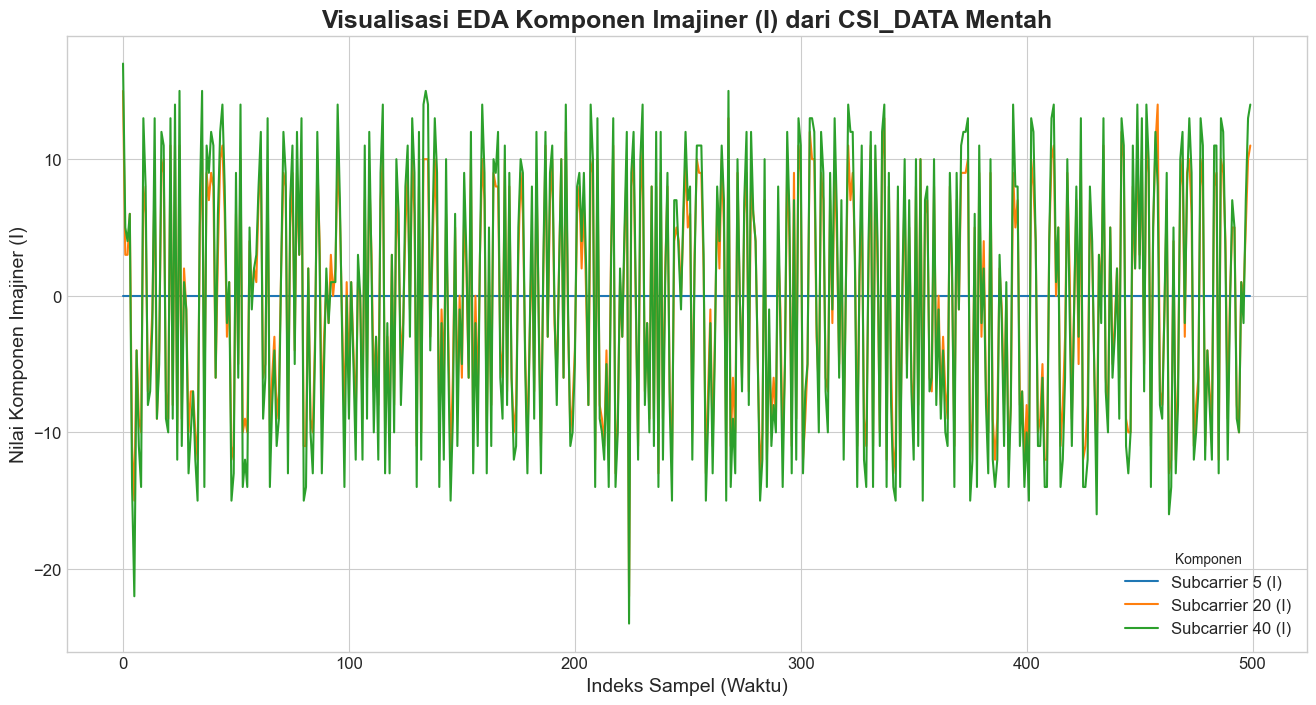

In [13]:
# --- 1. Persiapan Data (Menggunakan Variabel Anda) ---
# Kode ini mengasumsikan variabel 'activity_dataframes_rx1' sudah ada 
# di lingkungan Anda dan berisi daftar DataFrame.
# Kita akan memvisualisasikan data dari DataFrame pertama (indeks 0).
try:
    df_raw = activity_dataframes_rx1[0]
    print("Menggunakan data dari variabel 'activity_dataframes_rx1[0]'.")
except NameError:
    print("'activity_dataframes_rx1' tidak ditemukan. Membuat DataFrame dummy untuk demonstrasi.")
    # Fallback ke data dummy jika variabel tidak ada (untuk pengujian kode)
    dummy_data = {
        'CSI_DATA': [f"[{' '.join(map(str, np.random.randint(-128, 128, size=128)))}]" for _ in range(1000)]
    }
    df_raw = pd.DataFrame(dummy_data)
# --- Akhir Bagian Persiapan Data ---

# --- 2. Fungsi untuk Parsing Kolom 'CSI_DATA' ---
def parse_csi_string(csi_string):
    """Mengubah string '[num1 num2 ...]' menjadi list of integers."""
    if isinstance(csi_string, str):
        try:
            return [int(n) for n in csi_string.strip('[]').split()]
        except ValueError:
            return []
    return []

# --- 3. Ekstrak dan Proses Data CSI ---
# Terapkan fungsi parsing ke kolom 'CSI_DATA'
parsed_csi_list = df_raw['CSI_DATA'].apply(parse_csi_string).tolist()

# Ubah menjadi matriks NumPy 2D
# Hati-hati jika ada baris yang gagal di-parse dan menghasilkan list kosong
# Untuk keamanan, kita filter list yang tidak kosong
csi_data_matrix = np.array([row for row in parsed_csi_list if row])

# Pisahkan komponen Imajiner (I) dan Real (Q)
# I adalah kolom genap (0, 2, 4, ...), Q adalah kolom ganjil (1, 3, 5, ...)
imaginary_components = csi_data_matrix[:, 0::2]
real_components = csi_data_matrix[:, 1::2]


# --- 4. Kode untuk Membuat Visualisasi ---

# Pilih beberapa subcarrier untuk divisualisasikan
# Misalnya, kita pilih subcarrier ke-5, 20, dan 40
# Indeks kolom untuk komponen Imajiner dari subcarrier ini adalah 5, 20, dan 40
subcarrier_indices_to_plot = [5, 20, 40]

# Tentukan jumlah sampel yang ingin ditampilkan (misalnya, 500 sampel pertama)
samples_to_plot = 500

# Membuat plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))

# Loop untuk mem-plot komponen Imajiner (I) dari setiap subcarrier yang dipilih
for sc_index in subcarrier_indices_to_plot:
    if sc_index < imaginary_components.shape[1]: # Pastikan indeks tidak di luar batas
        ax.plot(imaginary_components[:samples_to_plot, sc_index], label=f'Subcarrier {sc_index} (I)')

# Menambahkan judul dan label pada plot
ax.set_title('Visualisasi EDA Komponen Imajiner (I) dari CSI_DATA Mentah', fontsize=18, fontweight='bold')
ax.set_xlabel('Indeks Sampel (Waktu)', fontsize=14)
ax.set_ylabel('Nilai Komponen Imajiner (I)', fontsize=14)
ax.legend(title='Komponen', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# Menampilkan plot
plt.show()

# Jika Anda ingin menyimpan plot sebagai file:
# fig.savefig('EDA_CSI_DATA_mentah.png', dpi=300, bbox_inches='tight')

## Extract amplitude from dataframes

In [14]:
# Loop melalui setiap dataframe dalam activity_dataframes_rx1
amp_dataframes_rx1 = []
for df_RX1 in activity_dataframes_rx1:
    data_RX1 = []
    for _, row_RX1 in df_RX1.iterrows():
        imaginary_RX1 = []
        real_RX1 = []
        amplitudes_RX1 = []

        csi_data = row_RX1['CSI_DATA']
        # Pastikan CSI_DATA adalah string sebelum diproses
        if isinstance(csi_data, str):
            # Parsing string menjadi daftar integer
            csi_matches = re.findall(r"\[(.*)\]", csi_data)
            if csi_matches:
                csi_string = csi_matches[0]
                csi_raw = [int(x) for x in csi_string.split(" ") if re.match(r"^-?\d+$", x)]



                # Pisahkan angka menjadi imaginary dan real
                for i in range(len(csi_raw)):
                    if i % 2 == 0:
                        imaginary_RX1.append(csi_raw[i])
                    else:
                        real_RX1.append(csi_raw[i])

                # Hitung amplitude
                for i in range(int(len(csi_raw) / 2)):
                    amplitudes_RX1.append(sqrt(imaginary_RX1[i] ** 2 + real_RX1[i] ** 2))
                
                data_RX1.append(amplitudes_RX1)
            else:
                print(f"Tidak ada kecocokan untuk baris: {csi_data}")
        else:
            print(f"Tipe data tidak valid untuk CSI_DATA: {type(csi_data)}")

    # Konversi data ke DataFrame dan tambahkan ke amp_dataframes_rx1
    temp_df_RX1 = pd.DataFrame(data_RX1)
    amp_dataframes_rx1.append(temp_df_RX1)

In [15]:
# Loop melalui setiap dataframe dalam activity_dataframes_rx2
amp_dataframes_rx2 = []
for df_RX2 in activity_dataframes_rx2:
    data_RX2 = []
    for _, row in df_RX2.iterrows():
        imaginary_RX2= []
        real_RX2 = []
        amplitudes_RX2 = []

        csi_data = row['CSI_DATA']
        # Pastikan CSI_DATA adalah string sebelum diproses
        if isinstance(csi_data, str):
            # Parsing string menjadi daftar integer
            csi_matches = re.findall(r"\[(.*)\]", csi_data)
            if csi_matches:
                csi_string = csi_matches[0]
                csi_raw = [int(x) for x in csi_string.split(" ") if x != '']

                # Pisahkan angka menjadi imaginary_RX2 dan real_RX2
                for i in range(len(csi_raw)):
                    if i % 2 == 0:
                        imaginary_RX2.append(csi_raw[i])
                    else:
                        real_RX2.append(csi_raw[i])

                # Hitung amplitude
                for i in range(int(len(csi_raw) / 2)):
                    amplitudes_RX2.append(sqrt(imaginary_RX2[i] ** 2 + real_RX2[i] ** 2))
                
                data_RX2.append(amplitudes_RX2)
            else:
                print(f"Tidak ada kecocokan untuk baris: {csi_data}")
        else:
            print(f"Tipe data tidak valid untuk CSI_DATA: {type(csi_data)}")

    # Konversi data ke DataFrame dan tambahkan ke amp_dataframes_rx2
    temp_df_RX2= pd.DataFrame(data_RX2)
    amp_dataframes_rx2.append(temp_df_RX2)

In [16]:
columns_to_drop = [0,1,2,3,4,5,32,59,60,61,62,63]

# Iterasi setiap DataFrame dalam list
for i in range(len(amp_dataframes_rx1)):
    amp_dataframes_rx1[i].drop(amp_dataframes_rx1[i].columns[columns_to_drop], axis=1, inplace=True)

# Sama untuk amp_dataframes_rx2 (jika itu juga list of DataFrames)
for i in range(len(amp_dataframes_rx2)):
    amp_dataframes_rx2[i].drop(amp_dataframes_rx2[i].columns[columns_to_drop], axis=1, inplace=True)

## VISUAL EDA

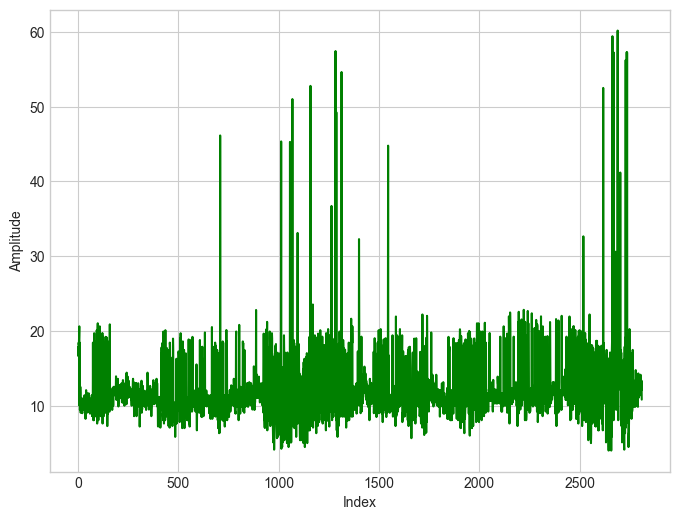

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(amp_dataframes_rx1[10][25],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
# plt.title('Raw CSI Amplitude Data: DD')
plt.show()

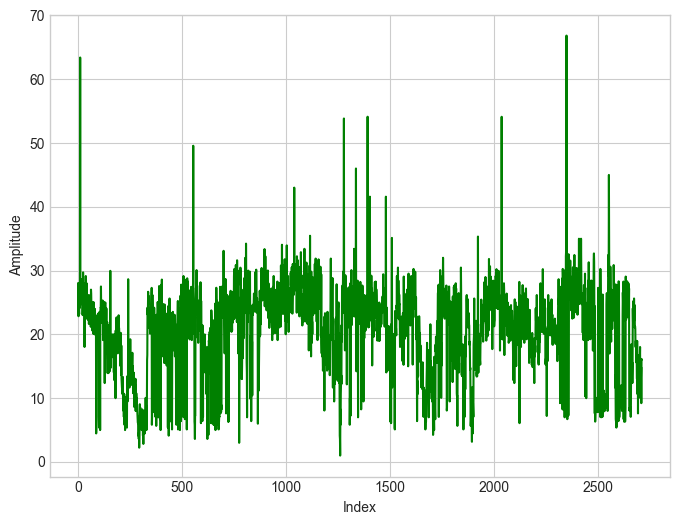

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(amp_dataframes_rx2[10][25],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
# plt.title('Raw CSI Amplitude Data: DD')
plt.show()

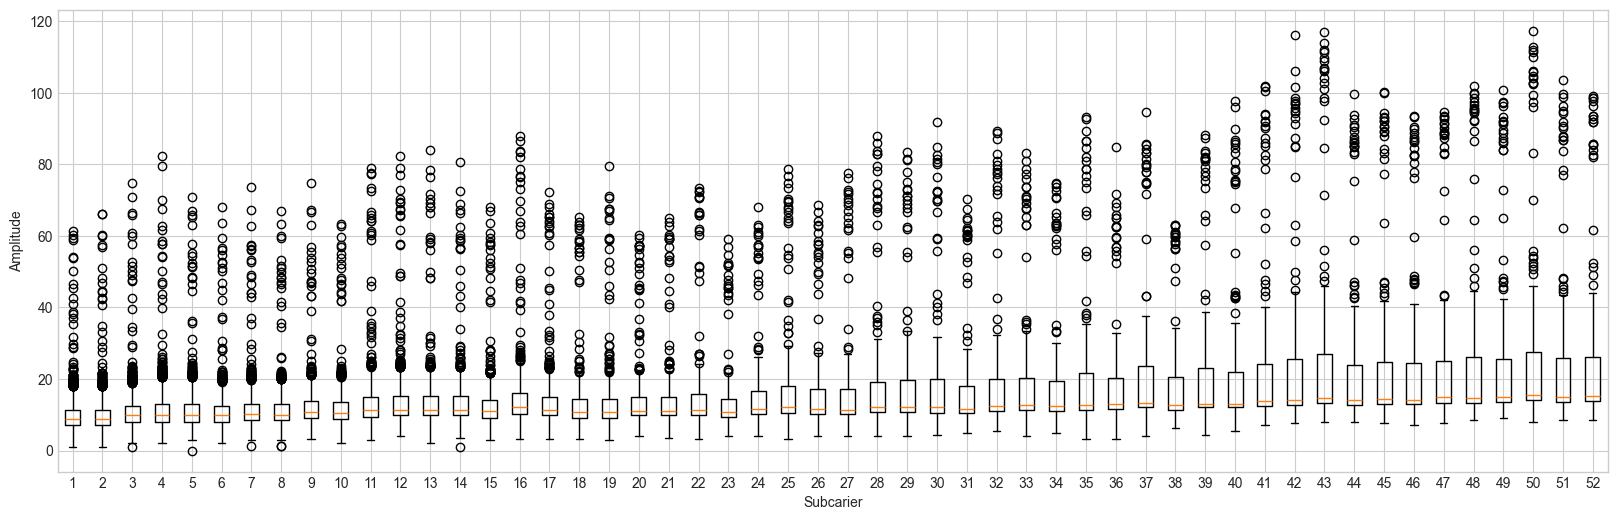

In [19]:
plt.figure(figsize=(20, 6))
plt.boxplot(amp_dataframes_rx1[10])
plt.xlabel('Subcarier')
plt.ylabel('Amplitude')
# plt.title('Boxplot of Before Denoising CSI Amplitude Data')
plt.show()

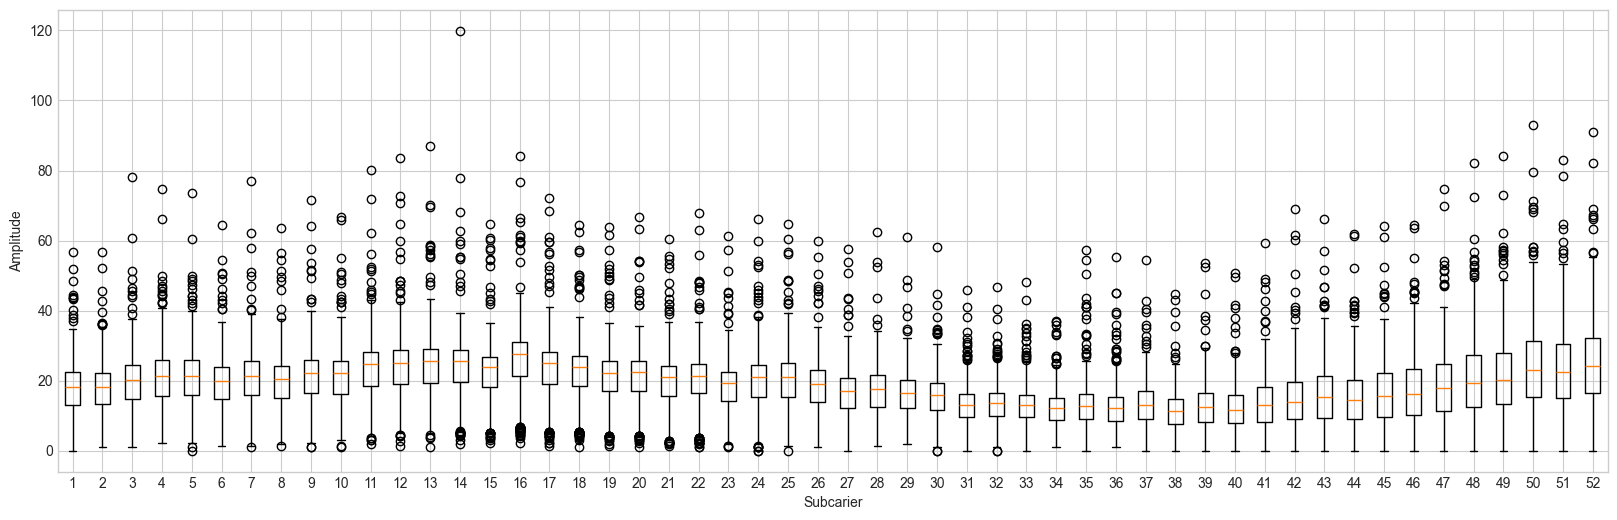

In [20]:
plt.figure(figsize=(20, 6))
plt.boxplot(amp_dataframes_rx2[10])
plt.xlabel('Subcarier')
plt.ylabel('Amplitude')
# plt.title('Boxplot of Before Denoising CSI Amplitude Data')
plt.show()

## Apply noise filter

In [21]:
denoised_dataframes_rx1 = []

for amplitude_RX1 in amp_dataframes_rx1:
    filtered_data_RX1 = pd.DataFrame()
    
    for col_RX1 in amplitude_RX1.columns:
        col_series = amplitude_RX1[col_RX1]
        # Hampel filter
        hampel_filtered = hampel(col_series, window_size=10)
        # Savitzky-Golay filter
        sg_filtered = savgol_filter(hampel_filtered.filtered_data
                                    , window_length=10, polyorder=3)
        filtered_data_RX1[col_RX1] = sg_filtered

    denoised_dataframes_rx1.append(filtered_data_RX1)


In [22]:
denoised_dataframes_rx2 = []

for amplitude_RX2 in amp_dataframes_rx2:
    filtered_data_RX2 = pd.DataFrame()
    
    for col_RX2 in amplitude_RX2.columns:
        col_series = amplitude_RX2[col_RX2]
        # Hampel filter
        hampel_filtered = hampel(col_series, window_size=10)
        # Savitzky-Golay filter
        sg_filtered = savgol_filter(hampel_filtered.filtered_data, window_length=10, polyorder=3)
        filtered_data_RX2[col_RX2] = sg_filtered

    denoised_dataframes_rx2.append(filtered_data_RX2)

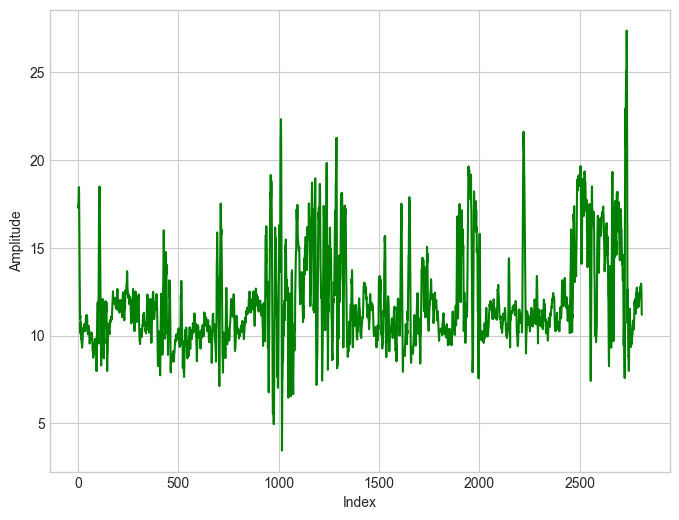

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(denoised_dataframes_rx1[10][25],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
# plt.title('Denoise CSI Amplitude Data: DD')
plt.show()

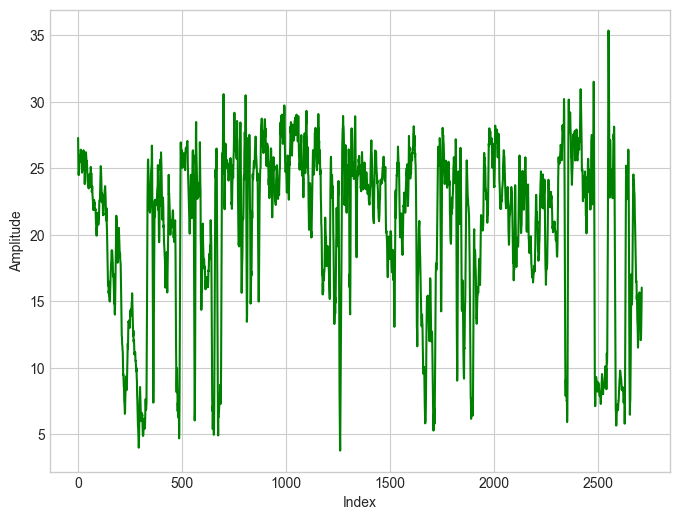

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(denoised_dataframes_rx2[10][25],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
# plt.title('Denoise CSI Amplitude Data: DD')
plt.show()

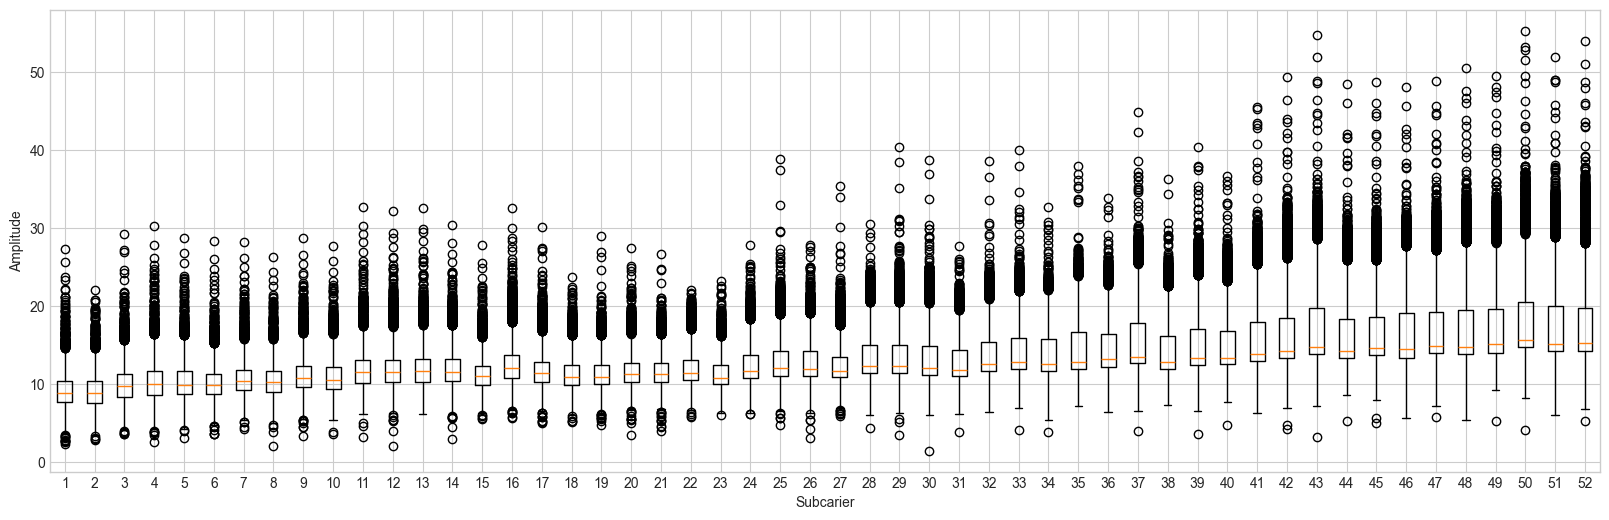

In [25]:
plt.figure(figsize=(20, 6))
plt.boxplot(denoised_dataframes_rx1[10])
plt.xlabel('Subcarier')
plt.ylabel('Amplitude')
# plt.title('Boxplot of Before Denoising CSI Amplitude Data')
plt.show()

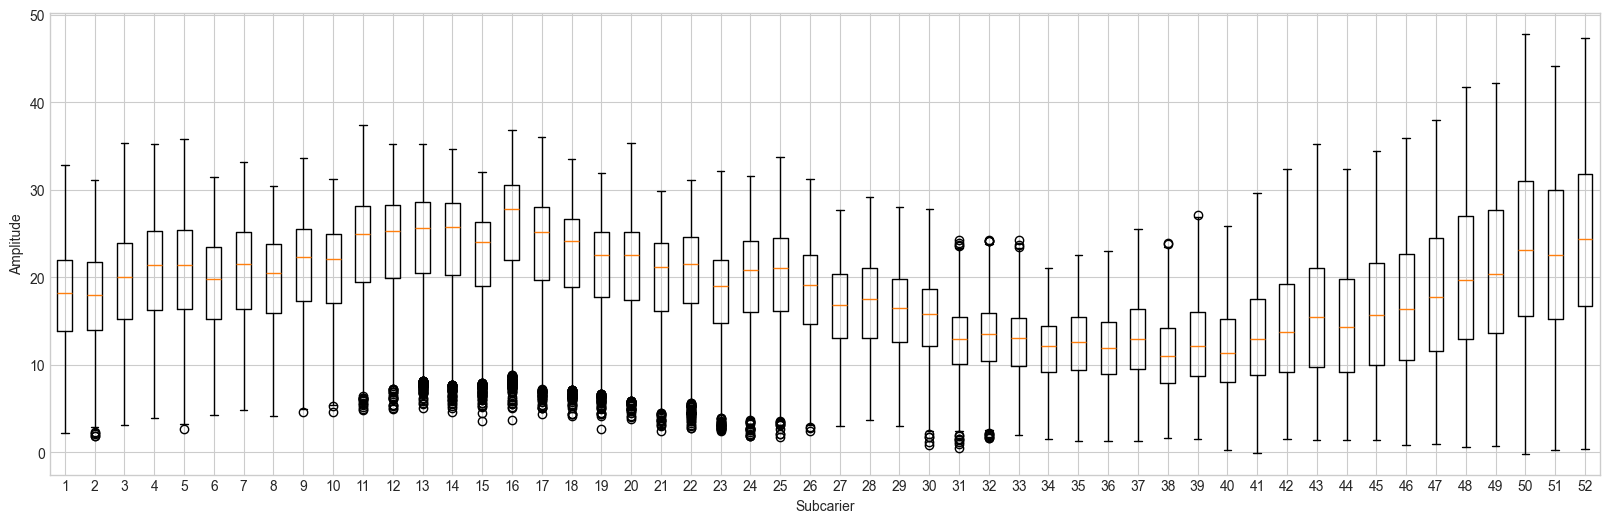

In [26]:
plt.figure(figsize=(20, 6))
plt.boxplot(denoised_dataframes_rx2[10])
plt.xlabel('Subcarier')
plt.ylabel('Amplitude')
# plt.title('Boxplot of Before Denoising CSI Amplitude Data')
plt.show()

In [27]:
denoised_dataframes_rx1[10].describe().to_csv('amp_dataframes_RX1_describe_denois_RX1.csv',index=False)

In [28]:
denoised_dataframes_rx1[10].describe()

,6,7,8,9,10,11,12,13,14,15,...,49,50,51,52,53,54,55,56,57,58
count,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,...,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000
mean,9.297825,9.232877,10.126011,10.514936,10.486585,10.289440,10.809172,10.607236,11.359441,11.064700,...,17.840986,16.737297,17.185333,17.034079,17.569284,17.745537,17.821711,18.886435,18.101643,18.345596
std,2.679458,2.510316,2.744641,2.985116,2.760483,2.498186,2.539783,2.452975,2.774579,2.591677,...,6.541657,5.419345,5.717359,5.752021,5.878295,6.359183,6.094285,6.891468,6.372149,6.668970
min,2.248352,2.805788,3.502668,2.502262,3.113576,3.540377,4.262426,1.978086,3.364719,3.607060,...,3.117604,5.240752,4.930311,5.579084,5.707976,5.340983,5.213013,4.042378,6.007834,5.246999
25%,7.604944,7.564784,8.367847,8.584252,8.638211,8.660231,9.167616,8.940788,9.541897,9.363242,...,13.837392,13.293733,13.630182,13.359123,13.895597,13.766598,13.953786,14.664710,14.157248,14.236096
50%,8.779946,8.759768,9.680210,10.015851,9.904757,9.865463,10.366647,10.192619,10.767693,10.520270,...,14.657999,14.259542,14.550423,14.415386,14.844370,14.750768,15.039782,15.560349,15.093759,15.206336
75%,10.389716,10.376088,11.251011,11.685285,11.666464,11.276939,11.815947,11.644821,12.336168,12.180038,...,19.720487,18.319838,18.514518,19.046988,19.201903,19.498411,19.603488,20.490348,19.985271,19.750765
max,27.245066,21.963434,29.205458,30.277082,28.745043,28.359676,28.166679,26.296865,28.661108,27.697107,...,54.674351,48.438740,48.673035,48.073711,48.807117,50.509087,49.501301,55.261086,51.855221,53.895935


In [29]:
denoised_dataframes_rx2[10].describe().to_csv('amp_dataframes_RX2_describe_denois_RX2.csv',index=False)

In [30]:
denoised_dataframes_rx2[10].describe()

,6,7,8,9,10,11,12,13,14,15,...,49,50,51,52,53,54,55,56,57,58
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,...,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000
mean,17.657751,17.513889,19.449350,20.573799,20.563988,18.980114,20.400831,19.467701,20.951982,20.512892,...,15.821136,14.752748,16.079821,16.878372,18.129927,19.888096,20.615057,23.229773,22.482981,24.137987
std,5.814671,5.570180,6.139627,6.365066,6.256573,5.693355,6.107353,5.588487,6.111360,5.868132,...,7.622656,7.061816,7.643529,8.012068,8.463585,9.218397,9.423437,10.482907,9.998086,10.540760
min,2.143766,1.864391,3.167226,3.961328,2.684572,4.210786,4.821920,4.130495,4.575437,4.585561,...,1.371287,1.447000,1.448799,0.863048,0.911993,0.596188,0.692689,-0.151312,0.311705,0.372176
25%,13.841766,13.981269,15.277035,16.226686,16.354122,15.208328,16.427900,15.900322,17.252001,17.112074,...,9.718747,9.139863,10.021195,10.527722,11.599820,12.921747,13.632047,15.623366,15.190765,16.706112
50%,18.245483,17.965494,20.047781,21.389471,21.407923,19.832823,21.512915,20.437769,22.293324,22.066216,...,15.416085,14.365832,15.668943,16.409878,17.768742,19.629635,20.379866,23.163660,22.534142,24.374104
75%,22.010778,21.706511,23.939177,25.312897,25.355244,23.468651,25.130655,23.754820,25.565474,24.956564,...,21.033274,19.837801,21.610729,22.616180,24.517130,27.028749,27.639242,30.973602,29.972591,31.829218
max,32.793442,31.140219,35.327995,35.281246,35.780205,31.436226,33.221596,30.460054,33.635307,31.251274,...,35.212727,32.375443,34.388531,35.904232,38.000717,41.713539,42.216156,47.843822,44.115532,47.348747


### Save Denoised Amplitudo To Folder RX 1|

In [31]:
# path folder
folder_path_RX1 = os.path.join('..', '..', 'data', 'filtered','dataset_scene2', 'data_denoising', 'datasetfilteredRX2')
print("Reading file:", folder_path_RX1)
# Buat folder jika belum ada
if not os.path.exists(folder_path_RX1):
    os.makedirs(folder_path_RX1)

counter = 1
prev_label = None

for i, dataframe in enumerate(denoised_dataframes_rx1):
    if label_list_rx1[i] != prev_label:
        counter = 1
        prev_label = label_list_rx1[i]
    
    filename = f"{label_list_rx1[i]}-{counter}.csv"
    counter += 1
    
    filepath = os.path.join(folder_path_RX1, filename)
    dataframe.to_csv(filepath, index=False)

Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX2


### Load Dataset Amplitudo RX1

In [32]:
# Tentukan folder tempat file CSV berada
folder_path_RX1 = os.path.join('..', '..', 'data', 'filtered','dataset_scene2', 'data_denoising', 'datasetfilteredRX1')
print("Reading file:", folder_path_RX1)
# Dapatkan daftar semua file dalam folder tersebut
file_list = [f for f in os.listdir(folder_path_RX1) if f.endswith('.csv')]

# Buat list untuk menyimpan setiap DataFrame
df_list_dd_RX1 = []
df_list_jl_RX1 = []
df_list_bd_RX1 = []



# Baca setiap file CSV, tambahkan kolom label, dan tambahkan ke list yang sesuai
for file_name in file_list:
    file_path = os.path.join(folder_path_RX1, file_name)
    df = pd.read_csv(file_path)
    print("Reading file:", file_path)  # Debugging
    if 'DD' in file_name:
        df['label'] = '0'
        df_list_dd_RX1.append(df)
    elif 'JL' in file_name:
        df['label'] = '1'
        df_list_jl_RX1.append(df)
    elif 'BD' in file_name:
        df['label']='2'
        df_list_bd_RX1.append(df)

# Gabungkan semua DataFrame dengan label '0' menjadi satu DataFrame
dd_df_RX1 = pd.concat(df_list_dd_RX1, ignore_index=True)

# Gabungkan semua DataFrame dengan label '1' menjadi satu DataFrame
jl_df_RX1 = pd.concat(df_list_jl_RX1, ignore_index=True)

# Gabungkan semua DataFrame dengan label '2' menjadi satu DataFrame
bd_df_RX1 = pd.concat(df_list_bd_RX1, ignore_index=True)

print('BD :', len(bd_df_RX1))
print('DD :',len(dd_df_RX1))
print('JL :',len(jl_df_RX1))



Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX1
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX1\BD-1.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX1\BD-10.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX1\BD-11.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX1\BD-12.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX1\BD-13.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX1\BD-14.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX1\BD-15.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX1\BD-2.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX1\BD-3.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX1\

In [33]:
print('BD :', len(bd_df_RX1))
print('DD :',len(dd_df_RX1))
print('JL :',len(jl_df_RX1))

print('Total = ',len(dd_df_RX1)+len(jl_df_RX1)+len(bd_df_RX1))

BD : 42336
DD : 43427
JL : 43052
Total =  128815


### Save Denoised Amplitudo To Folder RX 2

In [34]:
# path folder
# Path folder relatif dari notebooks
folder_path_RX2 = os.path.join('..', '..', 'data', 'filtered','dataset_scene2', 'data_denoising', 'datasetfilteredRX2')
print("Reading file:", folder_path_RX2)
# Buat folder jika belum ada
if not os.path.exists(folder_path_RX2):
    os.makedirs(folder_path_RX2)

counter = 1
prev_label = None

for i, dataframe in enumerate(denoised_dataframes_rx2):
    if label_list_rx2[i] != prev_label:
        counter = 1
        prev_label = label_list_rx2[i]
    
    filename = f"{label_list_rx2[i]}-{counter}.csv"
    counter += 1
    
    filepath = os.path.join(folder_path_RX2, filename)
    dataframe.to_csv(filepath, index=False)


Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX2


### Load Dataset Amplitudo RX2

In [35]:
# Tentukan folder tempat file CSV berada
folder_path_RX2 = os.path.join('..', '..', 'data', 'filtered','dataset_scene2', 'data_denoising', 'datasetfilteredRX2')
print("Reading file:", folder_path_RX2)
# Dapatkan daftar semua file dalam folder tersebut
file_list = [f for f in os.listdir(folder_path_RX2) if f.endswith('.csv')]
# Buat list untuk menyimpan setiap DataFrame
df_list_dd_RX2 = []
df_list_jl_RX2 = []
df_list_bd_RX2 = []



# Baca setiap file CSV, tambahkan kolom label, dan tambahkan ke list yang sesuai
for file_name in file_list:
    file_path = os.path.join(folder_path_RX2, file_name)
    df = pd.read_csv(file_path)
    print("Reading file:", file_path)  # Debugging
    if 'DD' in file_name:
        df['label'] = '0'
        df_list_dd_RX2.append(df)
    elif 'JL' in file_name:
        df['label'] = '1'
        df_list_jl_RX2.append(df)
    elif 'BD' in file_name:
        df['label']='2'
        df_list_bd_RX2.append(df)

# Gabungkan semua DataFrame dengan label '0' menjadi satu DataFrame
dd_df_RX2 = pd.concat(df_list_dd_RX2, ignore_index=True)

# Gabungkan semua DataFrame dengan label '1' menjadi satu DataFrame
jl_df_RX2 = pd.concat(df_list_jl_RX2, ignore_index=True)

# Gabungkan semua DataFrame dengan label '2' menjadi satu DataFrame
bd_df_RX2 = pd.concat(df_list_bd_RX2, ignore_index=True)

print('BD :', len(bd_df_RX2))
print('DD :',len(dd_df_RX2))
print('JL :',len(jl_df_RX2))


Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX2
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX2\BD-1.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX2\BD-10.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX2\BD-11.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX2\BD-12.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX2\BD-13.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX2\BD-14.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX2\BD-15.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX2\BD-2.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX2\BD-3.csv
Reading file: ..\..\data\filtered\dataset_scene2\data_denoising\datasetfilteredRX2\

In [36]:
print('BD :', len(bd_df_RX2))
print('DD :',len(dd_df_RX2))
print('JL :',len(jl_df_RX2))

print('Total = ',len(dd_df_RX2)+len(jl_df_RX2)+len(bd_df_RX2))

BD : 40871
DD : 43712
JL : 43224
Total =  127807


In [37]:
import matplotlib.pyplot as plt

# Hitung jumlah baris untuk setiap label dalam DataFrame dd_df
dd_counts = dd_df_RX1['label'].value_counts()
dd_counts_RX2 = dd_df_RX2['label'].value_counts()
# Hitung jumlah baris untuk setiap label dalam DataFrame jl_df
jl_counts = jl_df_RX1['label'].value_counts()
jl_counts_RX2 = jl_df_RX2['label'].value_counts()
# Hitung jumlah baris untuk setiap label dalam DataFrame bd_df
bd_counts = bd_df_RX1['label'].value_counts()
bd_counts_RX2 = bd_df_RX2['label'].value_counts()

# Gabungkan count RX1 dan RX2
dd_counts_total = dd_counts.add(dd_counts_RX2, fill_value=0)
jl_counts_total = jl_counts.add(jl_counts_RX2, fill_value=0)
bd_counts_total = bd_counts.add(bd_counts_RX2, fill_value=0)





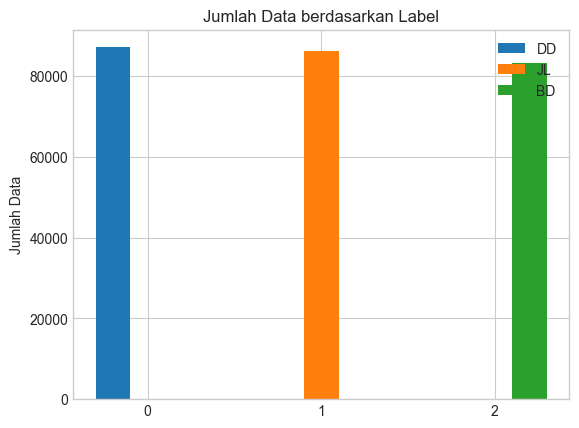

In [38]:
plot_bar_chart(dd_counts_total, jl_counts_total, bd_counts_total)

In [39]:
# Function to identify outliers using IQR
def iqr_outliers(df):
    numeric_df = df.select_dtypes(include=[np.number])
    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return outliers, numeric_df.columns

In [40]:
# dd_df_total = pd.concat([dd_df_RX1, dd_df_RX2], ignore_index=True)

# Panggil fungsi outlier detection
outliers_dd_rx1, numeric_cols_dd = iqr_outliers(dd_df_RX1)

# Print hasilnya
print("Outliers  duduk:")
outliers_dd_rx1

Outliers  duduk:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
0,30.923113,28.147990,30.822900,30.784006,30.826199,25.986282,28.225636,25.502800,27.416079,25.878070,...,18.308080,18.568290,18.940874,19.547352,19.142110,18.456835,18.998959,17.192802,18.009768,0
1,28.741852,26.493704,28.853779,28.977747,28.322695,25.223501,26.277418,23.781620,26.023785,23.962520,...,18.264502,18.704440,18.727497,19.102520,19.120266,18.074660,19.732018,17.627087,18.533752,0
2,26.944199,25.096596,27.201060,27.395071,26.279568,24.325888,24.729858,22.521614,24.734737,22.638021,...,17.970882,18.399021,18.118792,18.481522,18.670624,17.589659,19.723087,17.470152,18.247456,0
3,25.492660,23.949955,25.838789,26.047136,24.673853,23.376910,23.533657,21.664240,23.581793,21.804892,...,17.487509,17.781800,17.250753,17.754350,17.933240,17.024948,19.159330,16.888931,17.385452,0
4,24.349745,23.047071,24.741013,24.945103,23.482586,22.460030,22.639511,21.150959,22.597813,21.363451,...,16.874666,16.982533,16.259375,16.991000,17.048180,16.403646,18.227907,16.050364,16.182316,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42847,21.855865,21.848720,22.722197,23.325094,22.342420,20.425188,21.769710,19.862558,21.279642,22.306293,...,17.645150,18.313248,17.342358,18.230501,17.683872,17.388372,18.054815,16.001570,16.430600,0
42848,21.511570,21.970827,23.163622,23.433052,22.469383,20.581772,21.662752,20.247860,21.445179,21.879480,...,17.589329,18.090868,17.201612,18.266775,17.409433,17.668726,18.032852,15.892987,16.376616,0
42969,17.525866,16.591833,18.858704,19.176960,18.049088,16.655437,16.491800,17.104960,16.599712,16.710709,...,14.724336,14.291472,13.677731,13.904963,13.307249,14.026422,14.040608,12.477089,12.706298,0
42970,17.060670,16.086979,18.206436,19.044289,18.116837,16.472055,16.235228,16.390892,16.522612,16.041180,...,14.370817,13.849135,13.335020,13.449430,12.960938,13.597052,13.643266,12.097157,12.158871,0


In [41]:
# dd_df_total = pd.concat([dd_df_RX1, dd_df_RX2], ignore_index=True)

# Panggil fungsi outlier detection
outliers_dd_RX2, numeric_cols_dd_RX2 = iqr_outliers(dd_df_RX2)

# Print hasilnya
print("Outliers  duduk:")
outliers_dd_RX2

Outliers  duduk:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
0,25.139006,22.054405,25.868702,26.361303,24.403816,21.851624,23.835098,22.621740,23.631123,23.064892,...,20.670311,21.689674,20.534525,20.704720,21.736279,21.594908,22.766636,20.828560,20.916964,0
1,26.067047,24.260506,27.500801,27.952503,26.240921,23.280928,25.433012,23.170654,24.757698,23.921238,...,19.911192,21.738817,20.261139,20.506914,21.110474,20.799255,21.842249,19.867650,20.626717,0
2,26.211184,24.850697,27.917841,28.140123,26.776610,23.728344,25.774998,23.189130,24.886300,24.233421,...,19.057737,21.090109,19.588762,19.968748,20.347420,20.059864,20.929785,18.922903,19.907463,0
3,25.763243,24.270496,27.447685,27.318320,26.360695,23.452345,25.222898,22.835672,24.316254,24.145117,...,18.200985,20.014357,18.680363,19.231855,19.529520,19.403260,20.089400,18.065971,18.927300,0
4,24.915045,22.965420,26.418194,25.881248,25.342990,22.711405,24.138556,22.268772,23.346891,23.800000,...,17.431974,18.782373,17.698902,18.437868,18.739178,18.855963,19.381247,17.368511,17.854322,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43495,25.703434,25.395163,27.458666,27.103233,26.628857,25.208475,25.081600,24.609861,23.303259,23.536140,...,18.474745,18.889364,18.567040,18.492716,18.912199,19.125162,19.369608,18.045424,18.563234,0
43507,24.727835,25.518019,26.323114,27.118483,25.242155,24.936213,23.940794,24.046240,24.673920,24.197865,...,19.194395,19.285383,17.773415,18.978813,19.028502,19.027958,19.981090,18.635540,18.041084,0
43543,26.264929,26.571255,26.848854,27.890400,26.989996,25.687605,25.724090,25.437479,25.620829,25.195782,...,19.026842,19.359194,18.522990,19.443508,19.687582,19.940010,20.967420,18.926552,19.172760,0
43544,25.965225,26.167760,26.697098,27.268858,26.728018,25.664120,24.945349,25.195871,25.293371,25.196009,...,18.744417,19.259691,18.500404,19.298420,19.275229,19.928583,20.358519,18.531452,18.696308,0


In [42]:
# jl_df_total = pd.concat([jl_df_RX1, jl_df_RX2], ignore_index=True)

# Panggil fungsi outlier detection
outliers_jl_rx1, numeric_cols_jl = iqr_outliers(jl_df_RX1)

# Print hasilnya
print("Outliers  jalan:")
outliers_jl_rx1

Outliers  jalan:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
0,24.472637,25.489576,26.199003,27.337488,26.060732,24.020653,24.501650,23.400753,24.776136,24.002844,...,21.152590,21.793392,20.640740,21.777040,21.190600,21.092031,22.136984,21.246422,19.879091,1
1,26.103764,26.513487,27.083755,28.365395,26.919258,24.935104,25.748728,24.624060,25.697401,24.420050,...,20.470922,21.682362,20.774374,21.669537,21.298088,20.963260,21.503275,20.481377,20.256142,1
2,26.723768,26.627972,27.179684,28.416157,27.087982,25.044233,26.169504,24.782907,25.745000,24.377940,...,19.979645,21.168995,20.518470,21.067620,20.924767,20.505653,21.047680,19.687199,20.176090,1
3,26.616009,26.099810,26.746836,27.823717,26.792711,24.612250,26.009308,24.217737,25.218338,24.045296,...,19.637474,20.396692,20.028004,20.184622,20.276949,19.871176,20.716003,18.943645,19.804314,1
4,26.063839,25.195782,26.045260,26.922010,26.259254,23.903370,25.513466,23.268986,24.416817,23.590897,...,19.403124,19.508858,19.457947,19.233883,19.560946,19.211796,20.454054,18.330471,19.306189,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43047,30.417960,28.439320,32.570835,33.225075,31.094896,31.129673,29.438414,28.314795,30.424490,27.146616,...,22.596550,21.225440,21.221066,22.653439,21.108479,22.472008,23.101053,21.132349,22.307602,1
43048,31.055836,28.612322,31.868057,33.196790,30.953667,30.790854,29.218958,28.786673,29.893742,26.982466,...,22.203253,20.738594,20.443686,22.475630,21.119349,21.934732,22.716482,20.884974,22.197834,1
43049,30.082205,27.733604,29.811737,31.531734,29.557402,29.232252,27.999950,28.028244,27.940080,25.900782,...,20.777836,19.724375,19.112007,21.247328,20.114859,20.558903,21.412827,19.829744,21.102825,1
43050,26.985477,25.558613,26.270927,27.836128,26.695164,26.278875,25.640644,25.609703,24.346895,23.704190,...,18.202188,18.183245,17.292326,18.747301,17.871454,18.283066,19.138346,17.842901,18.799612,1


In [43]:
# jl_df_total = pd.concat([jl_df_RX1, jl_df_RX2], ignore_index=True)

# Panggil fungsi outlier detection
outliers_jl_RX2, numeric_cols_jl_RX2 = iqr_outliers(jl_df_RX2)

# Print hasilnya
print("Outliers  jalan:")
outliers_jl_RX2

Outliers  jalan:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
7,30.945982,28.861400,31.561783,31.405354,29.435034,28.962973,29.603458,27.602049,28.320597,26.801065,...,12.574161,12.356648,11.169144,10.892032,10.558506,10.251756,11.407804,9.473003,9.502574,1
8,31.747814,29.924229,32.569300,32.153190,30.594265,30.264164,30.949736,28.626987,28.803043,27.926561,...,11.919435,12.204556,10.926509,10.029897,9.627979,9.588091,10.695103,9.003471,9.108113,1
9,31.574387,30.248613,32.612236,32.511536,30.973581,30.637459,31.310854,29.156551,28.550920,28.534350,...,11.588361,11.870715,11.119712,9.722889,9.232402,9.261423,10.255682,8.803638,9.113891,1
10,31.226528,30.351564,32.288510,32.613224,30.949839,30.967052,31.333237,29.312859,28.313032,28.564690,...,11.560871,11.803246,10.648389,9.955773,8.558674,9.671473,10.121959,8.429894,9.119667,1
11,30.114183,30.041996,31.897408,32.231743,30.864218,30.228520,30.883238,29.045065,27.789661,28.458902,...,11.681088,11.724091,10.031757,9.997917,7.928554,9.828899,9.681035,8.145649,9.100677,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43075,26.450274,25.047504,28.186771,26.260595,27.358194,25.994896,25.938726,25.744495,25.333870,24.047539,...,14.347088,14.463553,13.601634,13.480968,12.579513,13.347133,13.196630,12.287382,11.996576,1
43076,26.530949,25.488170,28.575033,26.216545,27.770464,26.395254,25.820374,26.034834,25.859684,24.596428,...,14.490708,14.102811,13.937983,13.334237,12.085242,13.590640,13.155227,12.193635,11.917386,1
43077,25.937210,25.118206,28.247398,25.890331,27.573362,25.820540,25.191998,25.101185,25.653822,24.801165,...,14.413940,13.888003,13.683378,12.930019,11.737963,13.191510,13.085349,11.850176,11.645108,1
43078,25.761620,24.680902,27.972647,25.561634,27.620272,25.168526,24.870863,24.780195,25.195185,25.494238,...,14.150085,13.763329,13.640523,12.341991,11.578309,13.070016,12.807405,11.484114,11.131397,1


In [44]:
# bd_df_total = pd.concat([bd_df_RX1, bd_df_RX2], ignore_index=True)

# Panggil fungsi outlier detection
outliers_bd_rx1, numeric_cols_bd = iqr_outliers(bd_df_RX1)

# Print hasilnya
print("Outliers  berdiri:")
outliers_bd_rx1

Outliers  berdiri:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
1,15.242472,15.357273,16.702234,18.208597,16.552810,17.124899,18.243372,16.535383,18.681652,17.100924,...,27.378345,28.278383,27.369020,28.763311,29.976833,27.591263,32.217728,28.987682,30.678747,2
2,15.076676,15.529709,16.763103,18.318450,17.450954,17.085009,18.607800,16.794190,18.627708,17.037980,...,28.984882,30.243746,29.722824,31.031519,32.275550,29.818571,34.147750,31.092180,32.875520,2
3,14.401409,14.707865,15.794479,17.272055,16.950010,16.178144,17.813824,16.124930,17.513580,16.118498,...,28.327463,29.821114,29.366707,30.756544,31.710777,29.585800,33.229465,30.577070,32.205330,2
4,13.345934,13.233481,14.144515,15.456149,15.473831,14.683045,16.207253,14.801696,15.712403,14.651931,...,26.112299,27.690100,27.115099,28.661417,29.136372,27.602610,30.338083,28.239649,29.538841,2
3238,19.168066,17.904701,20.425417,19.676693,20.886032,19.287020,21.084341,17.945614,20.179909,21.214687,...,25.292465,26.450493,26.129637,27.365690,27.194006,27.360659,29.459911,27.853575,26.880348,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41852,12.038773,14.722442,15.556080,15.872676,16.794065,13.718143,16.130684,15.464246,16.524439,16.312260,...,28.869133,29.083155,29.334103,29.674070,30.975006,31.033089,33.393253,30.828820,31.737886,2
41855,13.493153,13.213141,14.812396,15.096827,15.481277,14.130749,15.599911,14.353691,15.696354,15.326000,...,25.538965,25.714285,25.804594,26.184462,27.604412,27.950628,28.896767,26.673700,28.045960,2
42039,11.869941,12.974036,15.107271,12.179638,13.260012,12.379585,13.889461,12.158200,15.417493,14.878936,...,28.033333,29.288560,29.604685,29.690912,31.517792,31.295225,34.557056,29.914509,31.726150,2
42040,12.059833,13.031623,15.082540,12.855016,14.206183,13.500940,15.289251,12.518386,16.261137,16.197222,...,26.094849,27.053564,27.723880,27.837282,29.117601,29.141323,31.795906,29.648357,29.429045,2


In [45]:
# bd_df_total = pd.concat([bd_df_RX1, bd_df_RX2], ignore_index=True)

# Panggil fungsi outlier detection
outliers_bd_RX2, numeric_cols_bd_RX2 = iqr_outliers(bd_df_RX2)

# Print hasilnya
print("Outliers  berdiri:")
outliers_bd_RX2

Outliers  berdiri:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
4593,14.683603,14.457973,15.475090,13.512445,15.557204,14.776633,13.220395,13.035282,12.828286,10.593026,...,28.559692,34.573402,32.116047,35.872383,40.541370,38.159760,44.775840,42.543340,46.039540,2
4594,15.112916,14.111507,16.171473,14.512381,15.091090,15.199227,14.109540,14.179728,11.998341,11.442370,...,28.707320,34.008568,32.030186,35.177210,39.798363,38.030920,45.358723,42.699380,45.080715,2
4596,14.080911,13.155980,14.603254,14.843045,13.919946,13.286174,14.657179,13.561535,12.071262,10.732745,...,29.470130,33.655800,33.411270,35.960890,38.708424,37.163696,43.152367,43.065704,46.197266,2
4609,13.415961,14.232371,13.548693,13.646158,12.814117,12.562548,13.286149,11.638306,11.992105,10.930122,...,30.604080,33.570377,33.464325,37.215130,41.133213,40.151814,44.961494,43.625420,46.693913,2
4610,13.346827,13.330106,13.133267,13.519867,12.353707,12.672533,13.751263,11.366274,11.012675,11.307343,...,30.452175,33.444770,33.038360,36.755947,40.925280,39.960213,45.310295,43.277416,45.801630,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39692,11.365970,11.557444,14.732322,16.450306,15.797488,16.463896,21.166138,17.530163,19.604252,20.435022,...,13.033736,12.526224,11.291149,8.488202,8.896498,8.547935,8.379914,6.413113,4.446438,2
39806,7.946468,7.566038,8.118813,9.751885,11.579187,9.932468,17.723259,10.550048,12.421166,14.709981,...,9.103994,7.486603,6.816070,5.660982,4.904651,3.451165,3.548571,2.731981,2.279206,2
39811,9.289826,10.821297,12.622596,13.963754,15.123958,14.999357,16.746405,16.347227,19.185856,22.811443,...,14.823121,13.606402,10.696590,10.381274,9.696206,7.731864,6.659594,6.109395,3.741238,2
39819,13.986832,14.785207,16.429554,17.878551,16.868557,15.574826,17.514840,19.939505,18.802680,23.617570,...,11.888431,12.101949,12.260500,9.929601,8.929659,9.079757,7.902840,6.271427,5.676759,2


C:\Users\fauza\AppData\Local\Temp\ipykernel_12016\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


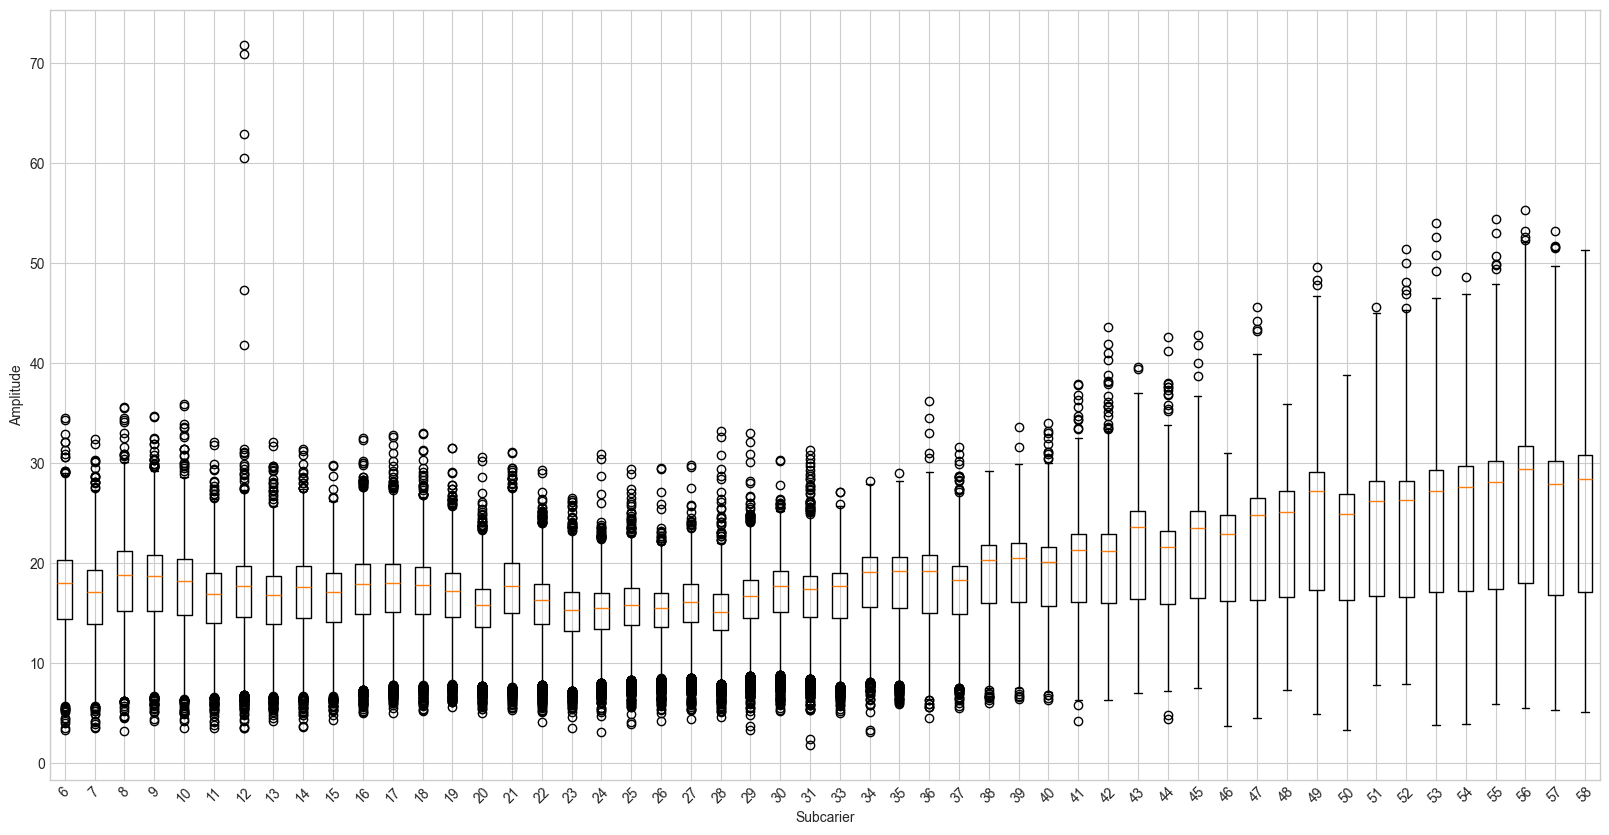

In [46]:
outliers_iqr_dd_without_label = outliers_dd_rx1.drop(columns=['label'])
plot_boxplots(outliers_iqr_dd_without_label,'Boxplot Before Normalization Amplituo Data')

C:\Users\fauza\AppData\Local\Temp\ipykernel_12016\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


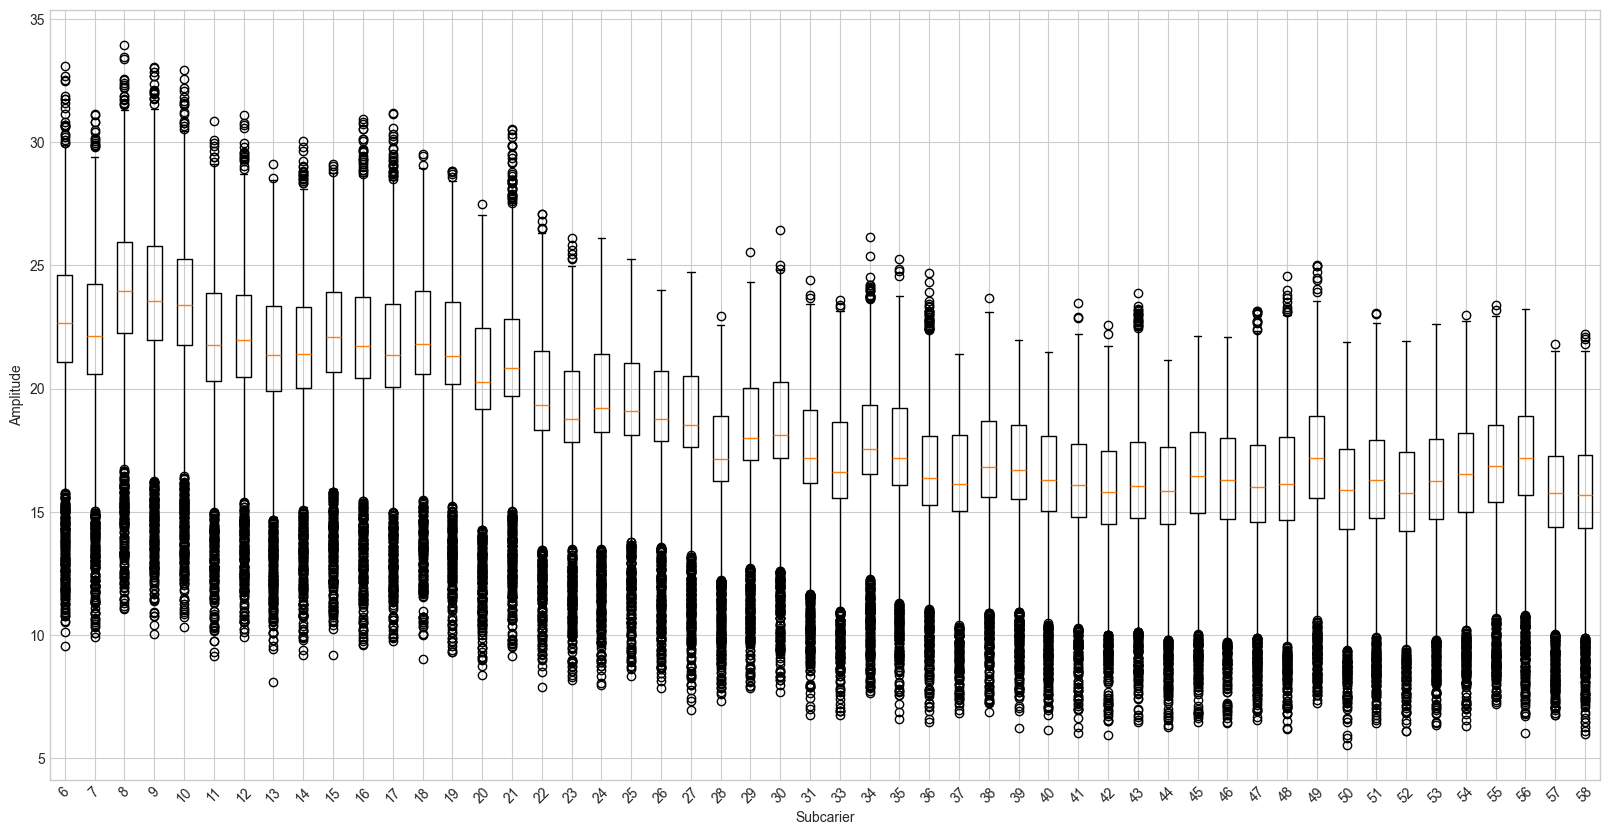

In [47]:
outliers_iqr_dd_without_label = outliers_dd_RX2.drop(columns=['label'])
plot_boxplots(outliers_iqr_dd_without_label,'Boxplot Before Normalization Amplituo Data')

In [48]:
cleaned_jl_df_RX1 = jl_df_RX1.drop(outliers_jl_rx1.index)
cleaned_bd_df_RX1 = bd_df_RX1.drop(outliers_bd_rx1.index)
cleaned_dd_df_RX1 = dd_df_RX1.drop(outliers_dd_rx1.index)

cleaned_jl_df_RX2 = jl_df_RX2.drop(outliers_jl_RX2.index)
cleaned_bd_df_RX2 = bd_df_RX2.drop(outliers_bd_RX2.index)
cleaned_dd_df_RX2 = dd_df_RX2.drop(outliers_dd_RX2.index)



# # gabungkan data RX 1 dan RX2 

combined_clean_jl_df = pd.concat([cleaned_jl_df_RX1, cleaned_jl_df_RX2], axis=0).reset_index(drop=True)
combined_clean_bd_df = pd.concat([cleaned_bd_df_RX1, cleaned_bd_df_RX2], axis=0).reset_index(drop=True)
combined_clean_dd_df = pd.concat([cleaned_dd_df_RX1, cleaned_dd_df_RX2], axis=0).reset_index(drop=True)


### save data setelah outlier removal

In [49]:
# Path untuk RX1 dan RX2
outlier_folder_rx1 = os.path.join('..', '..', 'data', 'filtered','dataset_scene2', 'outlier removal', 'dataset_outlier_removal_RX1')
outlier_folder_rx2 = os.path.join('..', '..', 'data', 'filtered','dataset_scene2', 'outlier removal', 'dataset_outlier_removal_RX2')

# Buat folder jika belum ada
os.makedirs(outlier_folder_rx1, exist_ok=True)
os.makedirs(outlier_folder_rx2, exist_ok=True)

# Simpan hasil RX1
cleaned_jl_df_RX1.to_csv(os.path.join(outlier_folder_rx1, 'JL.csv'), index=False)
cleaned_bd_df_RX1.to_csv(os.path.join(outlier_folder_rx1, 'BD.csv'), index=False)
cleaned_dd_df_RX1.to_csv(os.path.join(outlier_folder_rx1, 'DD.csv'), index=False)

# Simpan hasil RX2
cleaned_jl_df_RX2.to_csv(os.path.join(outlier_folder_rx2, 'JL.csv'), index=False)
cleaned_bd_df_RX2.to_csv(os.path.join(outlier_folder_rx2, 'BD.csv'), index=False)
cleaned_dd_df_RX2.to_csv(os.path.join(outlier_folder_rx2, 'DD.csv'), index=False)


### Load data setelah outlier removal

In [50]:
# Path folder
outlier_folder_rx1 = os.path.join('..', '..', 'data', 'filtered','dataset_scene2', 'outlier removal', 'dataset_outlier_removal_RX1')
outlier_folder_rx2 = os.path.join('..', '..', 'data', 'filtered','dataset_scene2', 'outlier removal', 'dataset_outlier_removal_RX2')

# Load data RX1
cleaned_jl_df_RX1 = pd.read_csv(os.path.join(outlier_folder_rx1, 'JL.csv'))
cleaned_bd_df_RX1 = pd.read_csv(os.path.join(outlier_folder_rx1, 'BD.csv'))
cleaned_dd_df_RX1 = pd.read_csv(os.path.join(outlier_folder_rx1, 'DD.csv'))

# Load data RX2
cleaned_jl_df_RX2 = pd.read_csv(os.path.join(outlier_folder_rx2, 'JL.csv'))
cleaned_bd_df_RX2 = pd.read_csv(os.path.join(outlier_folder_rx2, 'BD.csv'))
cleaned_dd_df_RX2 = pd.read_csv(os.path.join(outlier_folder_rx2, 'DD.csv'))

print("Data hasil outlier removal telah dimuat ulang.")

Data hasil outlier removal telah dimuat ulang.


In [51]:
# # gabungkan data RX 1 dan RX2 

combined_clean_jl_df = pd.concat([cleaned_jl_df_RX1, cleaned_jl_df_RX2], axis=0).reset_index(drop=True)
combined_clean_bd_df = pd.concat([cleaned_bd_df_RX1, cleaned_bd_df_RX2], axis=0).reset_index(drop=True)
combined_clean_dd_df = pd.concat([cleaned_dd_df_RX1, cleaned_dd_df_RX2], axis=0).reset_index(drop=True)

C:\Users\fauza\AppData\Local\Temp\ipykernel_12016\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


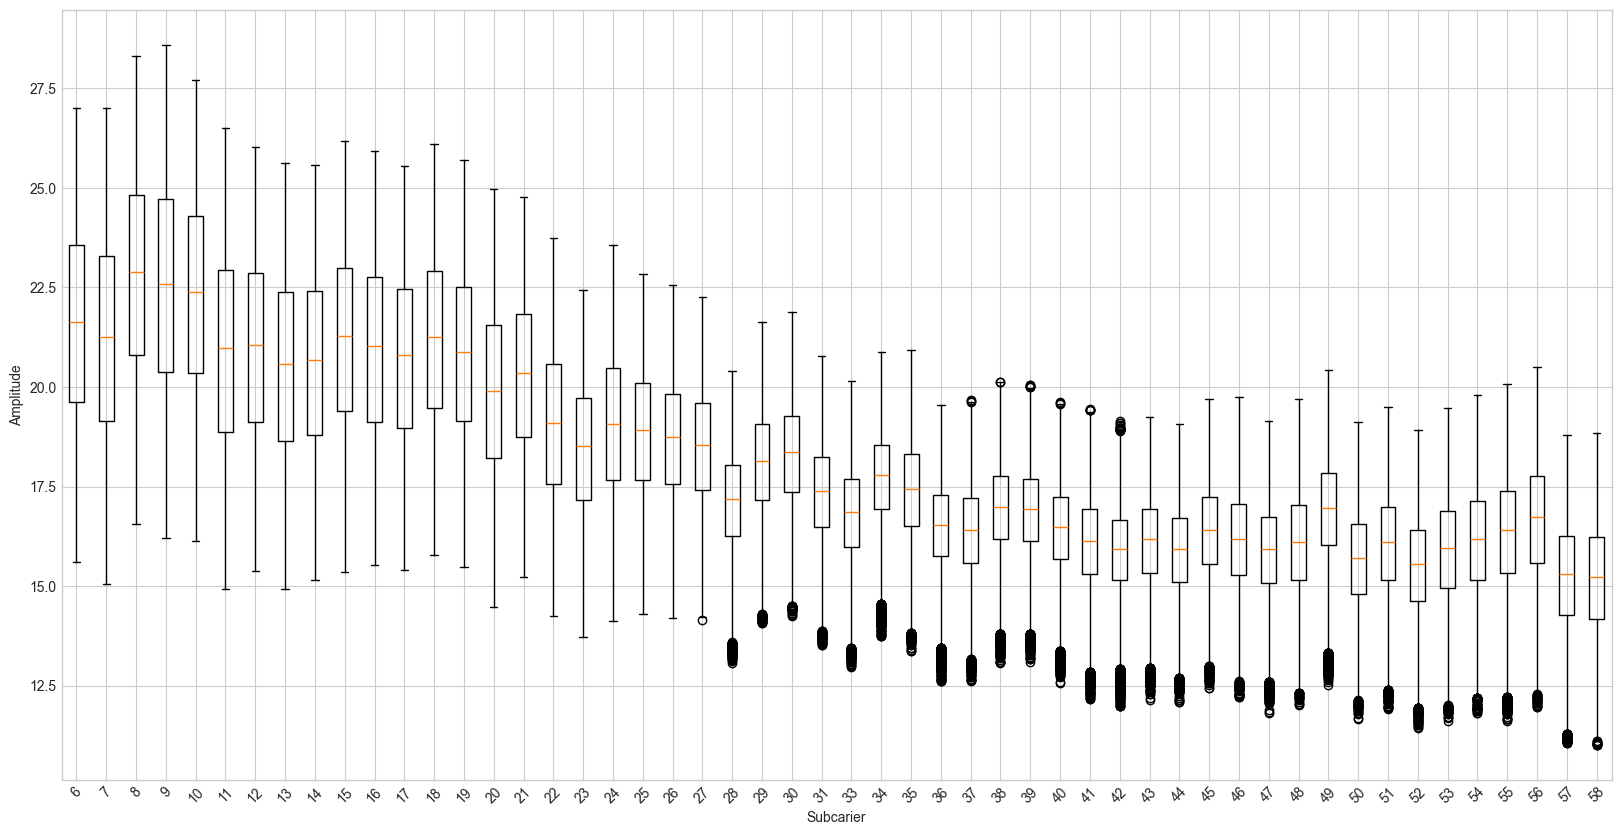

In [52]:
combined_clean_dd_df_without_label = combined_clean_dd_df.drop(columns=['label'])
plot_boxplots(combined_clean_dd_df_without_label,'Boxplot Before Normalization Amplituo Data')

In [53]:


print('BD :', len(combined_clean_bd_df))
print('DD :',len(combined_clean_dd_df))
print('JL :',len(combined_clean_jl_df))

print('Total = ',len(combined_clean_dd_df)+len(combined_clean_jl_df)+len(combined_clean_bd_df))

BD : 75456
DD : 75242
JL : 75050
Total =  225748


In [54]:
# Apply RobustScaler
scaler = RobustScaler()
scaled_jl_data = scaler.fit_transform(combined_clean_jl_df[numeric_cols_jl])
scaled_bd_data = scaler.fit_transform(combined_clean_bd_df[numeric_cols_bd])
scaled_dd_data = scaler.fit_transform(combined_clean_dd_df[numeric_cols_dd])

# scaler = RobustScaler()
# scaled_jl_data_RX1 = scaler.fit_transform(cleaned_jl_df_RX1[numeric_cols_jl])
# scaled_bd_data_RX1 = scaler.fit_transform(cleaned_bd_df_RX1[numeric_cols_bd])
# scaled_dd_data_RX1 = scaler.fit_transform(cleaned_dd_df_RX1[numeric_cols_dd])

# scaled_jl_data_RX2 = scaler.fit_transform(cleaned_jl_df_RX2[numeric_cols_jl_RX2])
# scaled_bd_data_RX2 = scaler.fit_transform(cleaned_bd_df_RX2[numeric_cols_bd_RX2])
# scaled_dd_data_RX2 = scaler.fit_transform(cleaned_dd_df_RX2[numeric_cols_dd_RX2])

# Convert the scaled data back to a DataFrame
scaled_jl_df_RX1 = pd.DataFrame(scaled_jl_data, columns=numeric_cols_jl, index=combined_clean_jl_df.index)
scaled_bd_df_RX1 = pd.DataFrame(scaled_bd_data, columns=numeric_cols_bd, index=combined_clean_bd_df.index)
scaled_dd_df_RX1 = pd.DataFrame(scaled_dd_data, columns=numeric_cols_dd, index=combined_clean_dd_df.index)

# scaled_jl_df_RX1 = pd.DataFrame(scaled_jl_data_RX1, columns=numeric_cols_jl, index=cleaned_jl_df_RX1.index)
# scaled_bd_df_RX1 = pd.DataFrame(scaled_bd_data_RX1, columns=numeric_cols_bd, index=cleaned_bd_df_RX1.index)
# scaled_dd_df_RX1 = pd.DataFrame(scaled_dd_data_RX1, columns=numeric_cols_dd, index=cleaned_dd_df_RX1.index)

# scaled_jl_df_RX2 = pd.DataFrame(scaled_jl_data_RX2, columns=numeric_cols_jl_RX2, index=cleaned_jl_df_RX2.index)
# scaled_bd_df_RX2 = pd.DataFrame(scaled_bd_data_RX2, columns=numeric_cols_bd_RX2, index=cleaned_bd_df_RX2.index)
# scaled_dd_df_RX2 = pd.DataFrame(scaled_dd_data_RX2, columns=numeric_cols_dd_RX2, index=cleaned_dd_df_RX2.index)

# If you want to combine the scaled numeric columns back with the non-numeric columns:
final_jl_df = pd.concat([scaled_jl_df_RX1, combined_clean_jl_df.drop(columns=numeric_cols_jl)], axis=1)
final_bd_df= pd.concat([scaled_bd_df_RX1, combined_clean_bd_df.drop(columns=numeric_cols_bd)], axis=1)
final_dd_df = pd.concat([scaled_dd_df_RX1, combined_clean_dd_df.drop(columns=numeric_cols_dd)], axis=1)

# final_jl_df_RX1 = pd.concat([scaled_jl_df_RX1, cleaned_jl_df_RX1.drop(columns=numeric_cols_jl)], axis=1)
# final_bd_df_RX1 = pd.concat([scaled_bd_df_RX1, cleaned_bd_df_RX1.drop(columns=numeric_cols_bd)], axis=1)
# final_dd_df_RX1 = pd.concat([scaled_dd_df_RX1, cleaned_dd_df_RX1.drop(columns=numeric_cols_dd)], axis=1)

# final_jl_df_RX2 = pd.concat([scaled_jl_df_RX2, cleaned_jl_df_RX2.drop(columns=numeric_cols_jl_RX2)], axis=1)
# final_bd_df_RX2 = pd.concat([scaled_bd_df_RX2, cleaned_bd_df_RX2.drop(columns=numeric_cols_bd_RX2)], axis=1)
# final_dd_df_RX2 = pd.concat([scaled_dd_df_RX2, cleaned_dd_df_RX2.drop(columns=numeric_cols_dd_RX2)], axis=1)

# #gabungkan final data RX1 dan RX 2
# # Gabungkan final data RX1 dan RX2
# combined_final_jl_df = pd.concat([final_jl_df_RX1, final_jl_df_RX2], axis=0).reset_index(drop=True)
# combined_final_bd_df = pd.concat([final_bd_df_RX1, final_bd_df_RX2], axis=0).reset_index(drop=True)
# combined_final_dd_df = pd.concat([final_dd_df_RX1, final_dd_df_RX2], axis=0).reset_index(drop=True)

### Save data setelah data_normalization

In [55]:
# Path folder simpan
normalized_mix_path = os.path.join('..', '..', 'data', 'filtered', 'dataset_scene2', 'normalization', 'dataset_normalized_MIX')

# Pastikan folder tujuan sudah ada
os.makedirs(normalized_mix_path, exist_ok=True)


# Simpan RX1
final_jl_df.to_csv(os.path.join(normalized_mix_path, 'JL.csv'), index=False)
final_bd_df.to_csv(os.path.join(normalized_mix_path, 'BD.csv'), index=False)
final_dd_df.to_csv(os.path.join(normalized_mix_path, 'DD.csv'), index=False)

print("Data normalisasi dari RX1 dan RX2 telah berhasil disimpan kembali ke dataset_scene2.")

Data normalisasi dari RX1 dan RX2 telah berhasil disimpan kembali ke dataset_scene2.


### Load data setelah data_normalization

In [56]:
normalized_rx1_path = os.path.join('..', '..', 'data', 'filtered','dataset_scene2', 'normalization', 'dataset_normalized_RX1')
normalized_rx2_path = os.path.join('..', '..', 'data', 'filtered','dataset_scene2', 'normalization', 'dataset_normalized_RX2')

final_jl_df_RX1 = pd.read_csv(os.path.join(normalized_rx1_path, 'JL.csv'))
final_bd_df_RX1 = pd.read_csv(os.path.join(normalized_rx1_path, 'BD.csv'))
final_dd_df_RX1 = pd.read_csv(os.path.join(normalized_rx1_path, 'DD.csv'))

# Load RX2
final_jl_df_RX2 = pd.read_csv(os.path.join(normalized_rx2_path, 'JL.csv'))
final_bd_df_RX2 = pd.read_csv(os.path.join(normalized_rx2_path, 'BD.csv'))
final_dd_df_RX2 = pd.read_csv(os.path.join(normalized_rx2_path, 'DD.csv'))

C:\Users\fauza\AppData\Local\Temp\ipykernel_12016\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


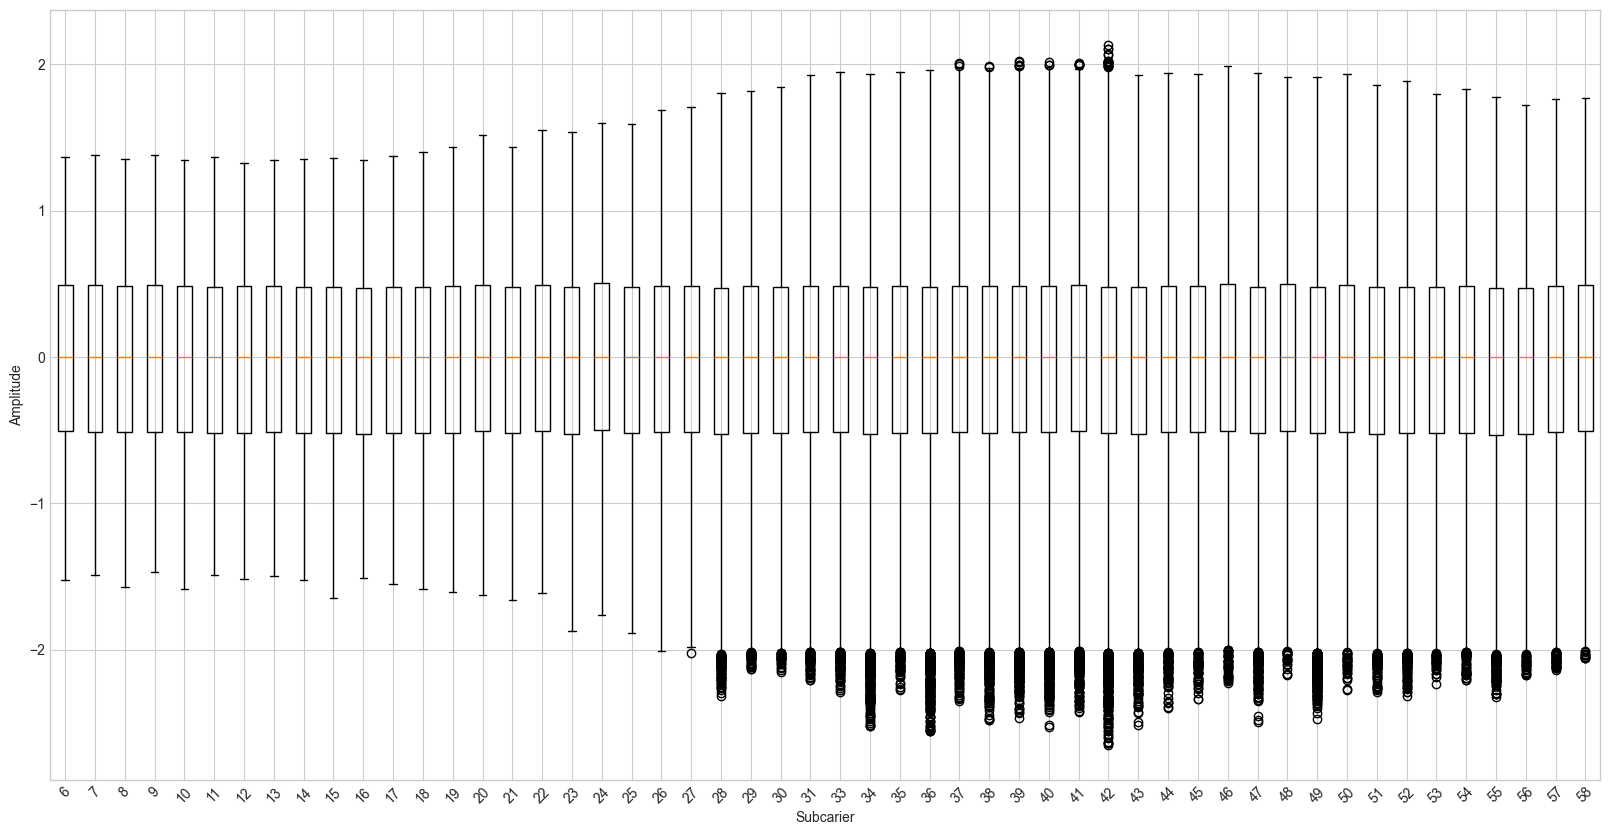

In [57]:
# final_without_dd_label = combined_final_dd_df.drop(columns=['label'])
# plot_boxplots(final_without_dd_label,'Boxplot after Normalization Amplituo Data')
final_without_dd_label = final_dd_df.drop(columns=['label'])
plot_boxplots(final_without_dd_label,'Boxplot after Normalization Amplituo Data')

C:\Users\fauza\AppData\Local\Temp\ipykernel_12016\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


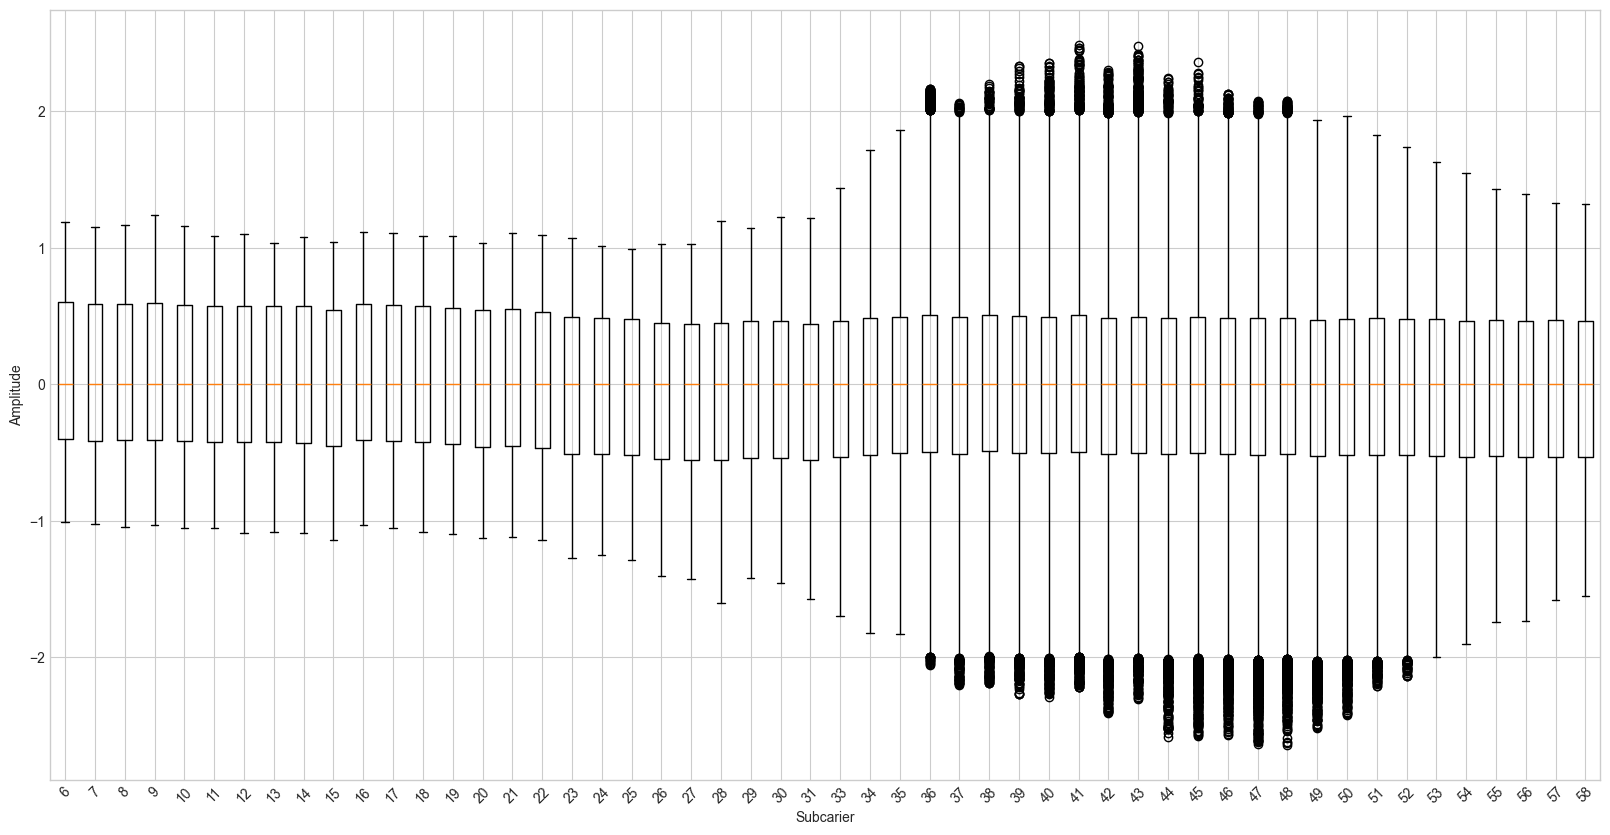

In [58]:
# final_without_dd_label = combined_final_dd_df.drop(columns=['label'])
# plot_boxplots(final_without_dd_label,'Boxplot after Normalization Amplituo Data')
final_without_jl_label = final_jl_df.drop(columns=['label'])
plot_boxplots(final_without_jl_label,'Boxplot after Normalization Amplituo Data')

C:\Users\fauza\AppData\Local\Temp\ipykernel_12016\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


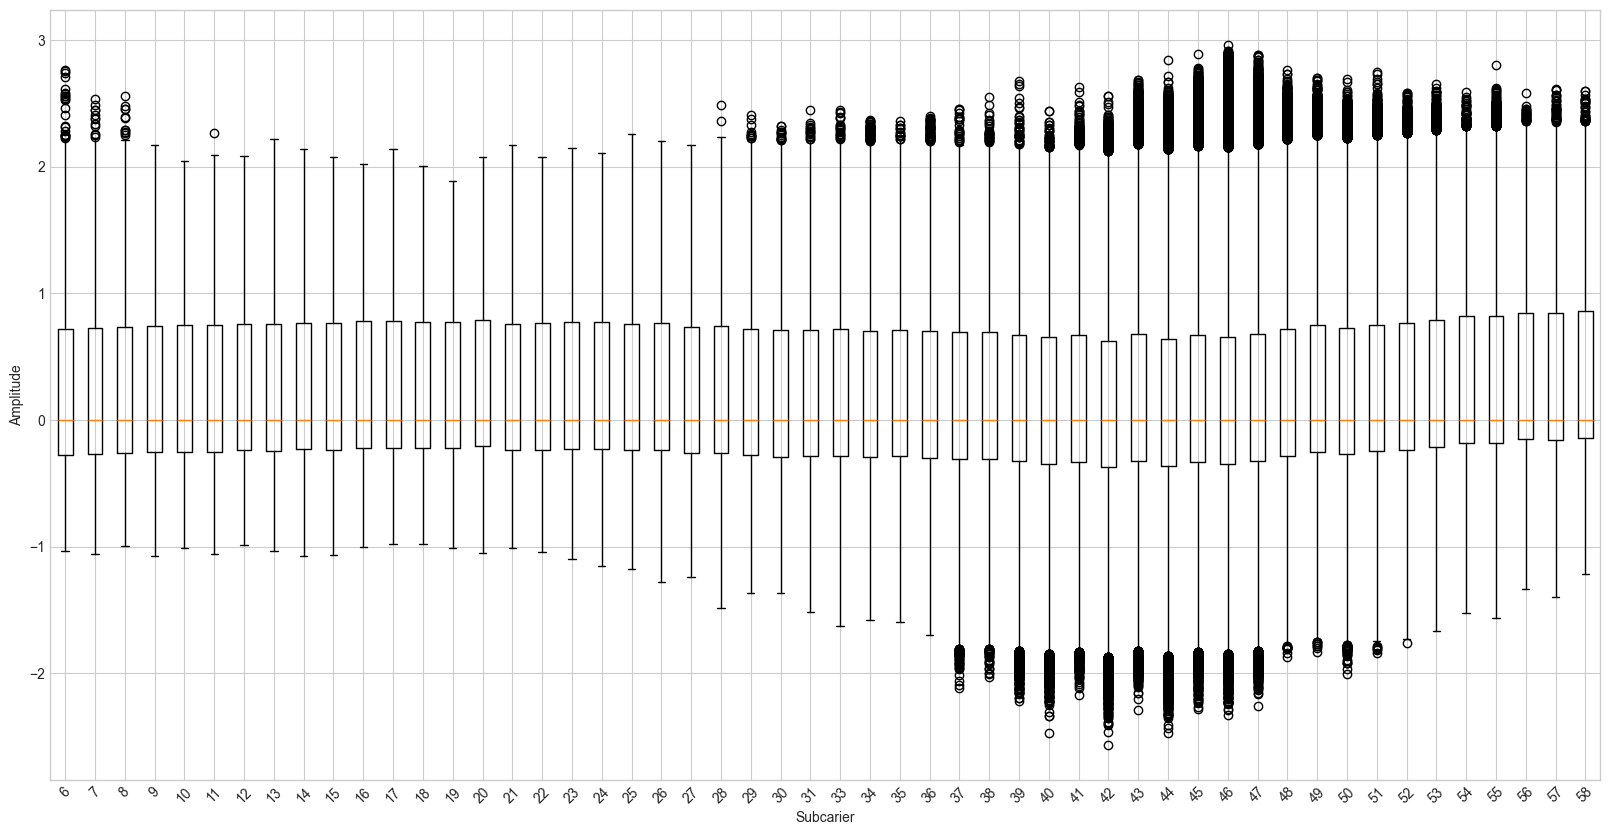

In [59]:
# final_without_dd_label = combined_final_dd_df.drop(columns=['label'])
# plot_boxplots(final_without_dd_label,'Boxplot after Normalization Amplituo Data')
final_without_bd_label = final_bd_df.drop(columns=['label'])
plot_boxplots(final_without_bd_label,'Boxplot after Normalization Amplituo Data')

In [60]:
print("dd Data after removing outliers and applying RobustScaler:")
final_dd_df
# combined_final_dd_df

dd Data after removing outliers and applying RobustScaler:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
0,0.240673,0.141639,0.015640,0.214188,0.005648,0.013376,0.097789,0.145664,0.148379,0.029208,...,-0.287694,-0.422621,-0.614882,-0.186302,-0.386781,-0.813734,-0.410275,-0.534118,-0.792375,0
1,0.136552,0.101587,-0.013328,0.120144,-0.014525,-0.005330,-0.033795,0.122033,0.050046,-0.030712,...,-0.662338,-0.749672,-0.998903,-0.546758,-0.804154,-1.241191,-0.796967,-0.869048,-1.232646,0
2,0.060154,0.175002,-0.011473,0.050433,0.142797,-0.006122,0.054291,0.287106,0.127567,0.025531,...,-0.820148,-1.037121,-1.048219,-0.894816,-1.040328,-1.548138,-1.192825,-1.280624,-1.337830,0
3,-0.005178,0.177459,-0.105781,0.018349,0.083029,-0.007079,0.040156,0.201064,0.151919,-0.001377,...,-1.043840,-1.160268,-1.088532,-1.145364,-1.339193,-2.077162,-1.206053,-1.440701,-1.363072,0
4,-0.211001,-0.003349,-0.298319,-0.040645,-0.109354,-0.086068,-0.076052,-0.011749,0.016582,-0.257614,...,-1.078098,-1.347305,-1.285371,-1.335242,-1.480984,-2.179769,-1.293211,-1.276255,-1.413483,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75237,0.593516,0.729186,0.322826,0.606301,0.431851,0.684273,0.581273,0.626144,0.548538,0.579304,...,0.969486,0.809226,0.835391,0.577965,0.930460,0.645622,0.645255,0.697862,0.823424,0
75238,0.682803,0.857617,0.309979,0.645744,0.487636,0.699921,0.629797,0.774588,0.515765,0.698834,...,1.005346,0.912134,0.938126,0.714623,1.284625,0.656804,0.683665,0.784602,0.907533,0
75239,0.775167,0.949922,0.394931,0.664277,0.572368,0.713774,0.666743,0.897449,0.580706,0.790674,...,0.998800,1.041717,0.945937,0.861419,1.522749,0.746989,0.753246,0.847506,0.908287,0
75240,0.852492,0.968346,0.612762,0.647383,0.698500,0.724439,0.692915,0.978759,0.789557,0.831113,...,0.931587,1.197997,0.850313,1.010149,1.543641,0.941495,0.867314,0.866344,0.799210,0


In [61]:
print("JL Data after removing outliers and applying RobustScaler:")
final_jl_df
# combined_final_jl_df

JL Data after removing outliers and applying RobustScaler:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
0,-0.080945,-0.093342,-0.125208,-0.051097,-0.142329,-0.134797,-0.140445,-0.193212,-0.218908,-0.235882,...,0.772446,0.581334,0.792823,0.768225,0.977346,0.688317,0.546988,0.652188,0.725254,1
1,-0.127134,-0.097495,-0.177249,-0.148612,-0.199885,-0.144657,-0.149206,-0.220838,-0.281532,-0.295958,...,0.524482,0.457593,0.421812,0.468907,0.644145,0.477263,0.386653,0.534502,0.512122,1
2,-0.237824,-0.191140,-0.281780,-0.306917,-0.345697,-0.256943,-0.285507,-0.332215,-0.429380,-0.437289,...,0.201699,0.131805,0.092257,-0.065974,0.270987,0.105718,0.100696,0.246087,0.258772,1
3,-0.314674,-0.269605,-0.304011,-0.439869,-0.441999,-0.354609,-0.391950,-0.433533,-0.534524,-0.508069,...,-0.098389,-0.189981,-0.399833,-0.454083,-0.229940,-0.150448,-0.085783,0.025650,-0.018103,1
4,-0.226000,-0.221647,-0.143688,-0.318663,-0.291718,-0.284190,-0.297632,-0.337155,-0.364046,-0.358002,...,0.024868,-0.151973,-0.151752,-0.148838,-0.053313,-0.026479,-0.053594,0.151404,0.078162,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75045,0.432273,0.432248,0.440568,0.420525,0.459074,0.428019,0.351416,0.475598,0.370500,0.489844,...,-0.718561,-1.118362,-1.048076,-0.911571,-0.693402,-0.803256,-0.910604,-0.902839,-0.772875,1
75046,0.445537,0.418078,0.429257,0.433599,0.457763,0.422893,0.386384,0.513981,0.412116,0.533451,...,-0.954748,-1.300108,-1.234646,-1.267159,-0.918660,-1.020879,-1.083545,-1.057596,-0.952662,1
75047,0.472437,0.412604,0.423402,0.444626,0.467577,0.429253,0.458672,0.539580,0.482371,0.581097,...,-1.124167,-1.336930,-1.354295,-1.468089,-1.100431,-1.161884,-1.184822,-1.113291,-0.986579,1
75048,0.511395,0.420881,0.424050,0.445593,0.490692,0.449164,0.571645,0.540300,0.582317,0.627186,...,-1.174522,-1.177748,-1.376990,-1.400067,-1.195352,-1.176804,-1.187299,-1.020214,-0.786330,1


In [62]:
print("BD Data after removing outliers and applying RobustScaler:")
final_bd_df
# combined_final_bd_df

BD Data after removing outliers and applying RobustScaler:


,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
0,0.238263,0.174383,0.189594,0.256060,0.070715,0.320145,0.284002,0.235159,0.338876,0.270262,...,0.990903,0.899373,0.686866,0.734669,0.707705,0.540252,0.713107,0.563320,0.579875,2
1,-0.088482,-0.110927,-0.136526,-0.068582,-0.026319,-0.040257,0.002279,-0.016723,-0.036518,-0.047265,...,0.914124,0.932923,0.832600,0.855115,0.725318,0.661936,0.612088,0.595377,0.560974,2
2,-0.205238,-0.227610,-0.270467,-0.204028,-0.182531,-0.197597,-0.160664,-0.193950,-0.173002,-0.177516,...,0.550065,0.542736,0.470331,0.510919,0.409433,0.399142,0.343534,0.355432,0.325407,2
3,-0.277049,-0.307598,-0.329564,-0.280594,-0.304382,-0.298873,-0.275116,-0.321894,-0.280790,-0.270813,...,0.257868,0.186279,0.165995,0.197152,0.152045,0.160036,0.108093,0.146344,0.121878,2
4,-0.374999,-0.427892,-0.452212,-0.403684,-0.415183,-0.409670,-0.409896,-0.443987,-0.401473,-0.355998,...,0.002972,-0.106823,-0.059766,-0.011125,-0.053955,-0.032943,-0.056767,-0.012823,-0.018622,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75451,0.319189,0.329981,0.479158,0.343157,0.436569,0.405504,0.475913,0.469221,0.427974,0.561321,...,-0.753105,-0.695760,-0.730439,-0.726482,-0.600099,-0.638968,-0.555488,-0.621634,-0.538121,2
75452,0.138378,0.084133,0.245292,0.083551,0.233747,0.182576,0.217603,0.218625,0.167795,0.304308,...,-1.018596,-0.930130,-0.944916,-0.915081,-0.778447,-0.789295,-0.709757,-0.755894,-0.667655,2
75453,0.185315,0.108264,0.243063,0.108962,0.301414,0.224183,0.220050,0.201225,0.197037,0.282434,...,-1.154368,-1.023196,-1.064783,-1.023854,-0.880012,-0.891481,-0.784170,-0.819156,-0.721388,2
75454,0.568922,0.545762,0.593870,0.563001,0.768726,0.659986,0.622714,0.540322,0.667898,0.621145,...,-1.067719,-0.887023,-1.025680,-0.994584,-0.855713,-0.908287,-0.726455,-0.763849,-0.653163,2


In [63]:
print(len(final_dd_df))
print(len(final_jl_df))
print(len(final_bd_df))

# print(len(combined_final_dd_df))
# print(len(combined_final_jl_df))
# print(len(combined_final_bd_df))


# print('Total = ',len(combined_final_dd_df)+len(combined_final_jl_df)+len(combined_final_bd_df))
print('Total = ',len(final_dd_df)+len(final_jl_df)+len(final_bd_df))

75242
75050
75456
Total =  225748


In [64]:
merged_df = pd.concat([final_dd_df,
                       final_jl_df,
                       final_bd_df
                       ], axis=0)

# merged_df = pd.concat([combined_final_dd_df,
#                        combined_final_jl_df,
#                        combined_final_bd_df
#                        ], axis=0)

merged_df

,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
0,0.240673,0.141639,0.015640,0.214188,0.005648,0.013376,0.097789,0.145664,0.148379,0.029208,...,-0.287694,-0.422621,-0.614882,-0.186302,-0.386781,-0.813734,-0.410275,-0.534118,-0.792375,0
1,0.136552,0.101587,-0.013328,0.120144,-0.014525,-0.005330,-0.033795,0.122033,0.050046,-0.030712,...,-0.662338,-0.749672,-0.998903,-0.546758,-0.804154,-1.241191,-0.796967,-0.869048,-1.232646,0
2,0.060154,0.175002,-0.011473,0.050433,0.142797,-0.006122,0.054291,0.287106,0.127567,0.025531,...,-0.820148,-1.037121,-1.048219,-0.894816,-1.040328,-1.548138,-1.192825,-1.280624,-1.337830,0
3,-0.005178,0.177459,-0.105781,0.018349,0.083029,-0.007079,0.040156,0.201064,0.151919,-0.001377,...,-1.043840,-1.160268,-1.088532,-1.145364,-1.339193,-2.077162,-1.206053,-1.440701,-1.363072,0
4,-0.211001,-0.003349,-0.298319,-0.040645,-0.109354,-0.086068,-0.076052,-0.011749,0.016582,-0.257614,...,-1.078098,-1.347305,-1.285371,-1.335242,-1.480984,-2.179769,-1.293211,-1.276255,-1.413483,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75451,0.319189,0.329981,0.479158,0.343157,0.436569,0.405504,0.475913,0.469221,0.427974,0.561321,...,-0.753105,-0.695760,-0.730439,-0.726482,-0.600099,-0.638968,-0.555488,-0.621634,-0.538121,2
75452,0.138378,0.084133,0.245292,0.083551,0.233747,0.182576,0.217603,0.218625,0.167795,0.304308,...,-1.018596,-0.930130,-0.944916,-0.915081,-0.778447,-0.789295,-0.709757,-0.755894,-0.667655,2
75453,0.185315,0.108264,0.243063,0.108962,0.301414,0.224183,0.220050,0.201225,0.197037,0.282434,...,-1.154368,-1.023196,-1.064783,-1.023854,-0.880012,-0.891481,-0.784170,-0.819156,-0.721388,2
75454,0.568922,0.545762,0.593870,0.563001,0.768726,0.659986,0.622714,0.540322,0.667898,0.621145,...,-1.067719,-0.887023,-1.025680,-0.994584,-0.855713,-0.908287,-0.726455,-0.763849,-0.653163,2


In [65]:
# threshold = 0.9  # 90% nilai 0

# # Hitung persentase nol di setiap kolom
# zero_ratio = (merged_df == 0).sum() / len(merged_df)

# # Cari kolom yang lebih dari threshold
# columns_to_drop = zero_ratio[zero_ratio > threshold].index.tolist()

# print("Kolom yang mostly nol (>90%):")
# print(columns_to_drop)


In [66]:
merged_df.describe()

,6,7,8,9,10,11,12,13,14,15,...,50,51,52,53,54,55,56,57,58,label
count,2.257480e+05,2.257480e+05,225748.000000,2.257480e+05,2.257480e+05,225748.000000,2.257480e+05,225748.000000,2.257480e+05,2.257480e+05,...,2.257480e+05,225748.000000,2.257480e+05,2.257480e+05,2.257480e+05,225748.000000,2.257480e+05,2.257480e+05,225748.000000,225748.000000
mean,1.063167e-01,1.049598e-01,0.098213,1.057496e-01,9.690928e-02,0.097339,9.319040e-02,0.093861,9.161342e-02,7.917613e-02,...,5.290685e-02,0.053641,5.606113e-02,6.118031e-02,6.930849e-02,0.065934,7.463438e-02,7.956969e-02,0.087464,1.000948
std,6.069406e-01,6.043377e-01,0.596269,5.876346e-01,5.899609e-01,0.591421,5.842145e-01,0.587662,5.786061e-01,5.831233e-01,...,7.689773e-01,0.751293,7.442140e-01,7.263277e-01,7.113450e-01,0.711850,6.909024e-01,6.886888e-01,0.678550,0.817038
min,-1.525454e+00,-1.491148e+00,-1.570694,-1.472219e+00,-1.583915e+00,-1.490733,-1.520987e+00,-1.497277,-1.523763e+00,-1.646934e+00,...,-2.420433e+00,-2.287881,-2.316602e+00,-2.232167e+00,-2.210783e+00,-2.326505,-2.177203e+00,-2.139882e+00,-2.057865,0.000000
25%,-3.758532e-01,-3.816894e-01,-0.372724,-3.675159e-01,-3.703498e-01,-0.377415,-3.719435e-01,-0.376486,-3.666960e-01,-3.780574e-01,...,-4.212873e-01,-0.411964,-4.025246e-01,-3.954048e-01,-3.775233e-01,-0.386279,-3.692086e-01,-3.746464e-01,-0.366740,0.000000
50%,1.865505e-16,-1.887024e-16,0.000000,6.796751e-17,7.337169e-17,0.000000,-4.741797e-16,0.000000,7.468162e-17,4.939142e-16,...,-9.504141e-16,0.000000,3.946276e-16,8.837772e-17,-9.005377e-16,0.000000,1.275200e-16,1.360091e-16,0.000000,1.000000
75%,5.799821e-01,5.749099e-01,0.575551,5.829430e-01,5.734238e-01,0.570123,5.707216e-01,0.571536,5.717103e-01,5.554991e-01,...,5.231284e-01,0.521164,5.265317e-01,5.285291e-01,5.341265e-01,0.528170,5.336715e-01,5.369645e-01,0.544218,2.000000
max,2.766323e+00,2.535299e+00,2.562048,2.168770e+00,2.047262e+00,2.269807,2.088427e+00,2.220143,2.139343e+00,2.077194e+00,...,2.693344e+00,2.747763,2.585776e+00,2.655320e+00,2.592957e+00,2.804381,2.578769e+00,2.613095e+00,2.601193,2.000000


## Split Data

In [67]:
# Set seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [68]:
from sklearn.model_selection import train_test_split

# Asumsikan merged_df sudah didefinisikan sebelumnya
X = merged_df.iloc[:, :-1]
y = merged_df.iloc[:, -1]
# # Gabungkan menjadi satu dataframe
data = X.copy()
data['label'] = y
# # Drop NaN di seluruh data
data = data.dropna()

# # Pisahkan lagi
X = data.drop(columns=['label'])
y = data['label']
# Baris-baris di atas adalah persiapan data Anda, biarkan seperti itu.
# Kita akan fokus pada bagian setelah X dan y siap.

# Tahap 1: Pisahkan data menjadi data latih (70%) dan data sementara (30%)
# Data sementara ini akan dibagi lagi menjadi validasi dan uji.
# Gunakan stratify=y jika Anda ingin menjaga proporsi kelas (berguna untuk klasifikasi)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,  # 30% untuk data sementara (validasi + uji)
    random_state=seed,
    shuffle=True,
    stratify=y # Tambahkan jika y adalah target klasifikasi dan Anda ingin stratifikasi
)

# Tahap 2: Pisahkan data sementara (30% dari total) menjadi data validasi dan data uji.
# Kita ingin validasi 20% dari total dan uji 10% dari total.
# Dari data sementara (30%), kita ambil 1/3 untuk uji (0.30 * 1/3 = 0.10 atau 10% dari total).
# Sisanya (2/3 dari data sementara) akan menjadi data validasi (0.30 * 2/3 = 0.20 atau 20% dari total).
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.3333,  # Sekitar 1/3 dari X_temp untuk data uji (menghasilkan 10% dari total data)
    random_state=seed,
    shuffle=True,
    stratify=y_temp # Tambahkan jika y_temp adalah target klasifikasi dan Anda ingin stratifikasi
)

# Sekarang Anda memiliki:
# X_train, y_train (70% dari data asli)
# X_val, y_val (20% dari data asli, untuk validasi)
# X_test, y_test (10% dari data asli, untuk pengujian akhir)

print(f"Ukuran X_train: {X_train.shape}, Ukuran y_train: {y_train.shape}")
print(f"Ukuran X_val: {X_val.shape}, Ukuran y_val: {y_val.shape}")
print(f"Ukuran X_test: {X_test.shape}, Ukuran y_test: {y_test.shape}")

Ukuran X_train: (158023, 52), Ukuran y_train: (158023,)
Ukuran X_val: (45152, 52), Ukuran y_val: (45152,)
Ukuran X_test: (22573, 52), Ukuran y_test: (22573,)


In [69]:
# Hitung jumlah sampel di setiap kelas pada y_train (sebelum SMOTE)
unique_classes_before, class_counts_before = np.unique(y_train, return_counts=True)

# Tampilkan jumlah sampel di setiap kelas sebelum SMOTE
print("Jumlah sampel di setiap kelas SEBELUM SMOTE:")
for cls, count in zip(unique_classes_before, class_counts_before):
    print(f"Kelas {cls}: {count} sampel")

Jumlah sampel di setiap kelas SEBELUM SMOTE:
Kelas 0: 52669 sampel
Kelas 1: 52535 sampel
Kelas 2: 52819 sampel


In [70]:
from imblearn.over_sampling import SMOTE


# Terapkan SMOTE
smote = SMOTE(random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# X_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)

print("Shape data setelah SMOTE:")
print(f"X_train_smote: {X_train_smote.shape}, y_train_smote: {y_train_smote.shape}")
# print(f"X_test_smote: {X_test_smote.shape}, y_test_smote: {y_test_smote.shape}")

Shape data setelah SMOTE:
X_train_smote: (158457, 52), y_train_smote: (158457,)


In [71]:
# Hitung jumlah sampel di setiap kelas
unique_classes, class_counts = np.unique(y_train_smote, return_counts=True)

# Tampilkan jumlah sampel di setiap kelas
for cls, count in zip(unique_classes, class_counts):
    print(f"Kelas {cls}: {count} sampel")


Kelas 0: 52819 sampel
Kelas 1: 52819 sampel
Kelas 2: 52819 sampel


In [72]:
class_counts

array([52819, 52819, 52819], dtype=int64)

In [73]:
unique_classes


array([0, 1, 2], dtype=int64)

In [74]:
dd_counts_smote = {str(0): class_counts[0]}
jl_counts_smote = {str(1): class_counts[1]}
bd_counts_smote = {str(2): class_counts[2]}


In [75]:
dd_counts_smote

{'0': 52819}

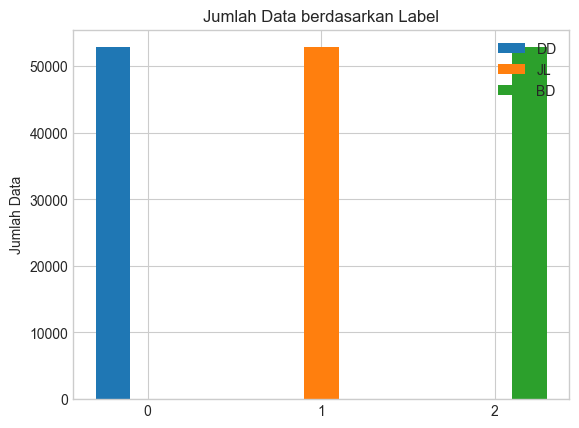

In [76]:
plot_bar_chart(dd_counts_smote, jl_counts_smote, bd_counts_smote)

In [77]:
print(X_train_smote.shape)
print(y_train_smote.shape)


(158457, 52)
(158457,)


In [78]:
# print(X_test_smote.shape)
# print(y_test_smote.shape)

# Trainng With Filtration and Normalization (Robust Scaler) Balancing (SMOTE)



In [79]:
# Cukup definisikan kelas Attention satu kali
import tensorflow as tf
# import numpy as np # Sudah diimpor biasanya
# import itertools # Untuk plot_confusion_matrix
# import matplotlib.pyplot as plt # Untuk plot_confusion_matrix dan plot history

class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        dim = int(input_shape[-1]) # Pastikan integer
        self.W = self.add_weight(name="att_weight", shape=(dim, dim), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(dim,), initializer="zeros", trainable=True)
        self.u = self.add_weight(name="att_u", shape=(dim,), initializer="glorot_uniform", trainable=True)
        super(Attention, self).build(input_shape) # Panggil build parent

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), 1)
        return output

    def get_config(self): # Penting untuk save/load model dengan custom layer
        config = super(Attention, self).get_config()
        return config

In [80]:
def get_MLP_model(input_dim, learning_rate,num_classes, lstm_units, dense_units):
    InputLayer = tf.keras.layers.InputLayer
    Dense = tf.keras.layers.Dense
    LSTM = tf.keras.layers.LSTM
    Dropout = tf.keras.layers.Dropout

    model = tf.keras.Sequential(
      [
          InputLayer(input_shape=input_dim),
          LSTM(lstm_units, return_sequences=True),
          Attention(),
        #   Dropout(dropout_rate),
          Dense(dense_units, activation=tf.nn.relu),
        #   Dropout(dropout_rate),
          Dense(num_classes, activation=tf.nn.softmax)
      ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [81]:
# def get_MLP_model(input_dim, learning_rate, num_classes):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Input(shape=input_dim),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Dense(num_classes, activation='softmax')
#     ])
    
#     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
#     model.compile(
#         loss='sparse_categorical_crossentropy', 
#         optimizer=optimizer, 
#         metrics=['accuracy']
#     )
    
#     return model


In [82]:
# --- Persiapan Data untuk Model ---
# Data Latih (hasil SMOTE)
flat_data = np.array(X_train_smote) # Ini sudah benar jika X_train_smote adalah hasil SMOTE dari training split
flat_data = flat_data.reshape((X_train_smote.shape[0], 1, flat_data.shape[1]))
label_in = np.array(y_train_smote)
label_in = label_in.astype(np.float64)

# Menambah Dimensi Baru: Penambahan dimensi baru (dengan nilai 1) sering kali diperlukan untuk menyesuaikan 
# data ke dalam bentuk yang diharapkan oleh model tertentu. Misalnya, model LSTM atau CNN sering kali 
# memerlukan input dengan tiga dimensi (batch size, number of channels, number of features/timesteps).

# Keseragaman Bentuk Data: Mengubah bentuk data menjadi konsisten dan sesuai dengan persyaratan 
# input dari model yang akan digunakan. Ini penting untuk memastikan bahwa data dapat diproses 
# dengan benar oleh lapisan-lapisan dalam model.

In [83]:
# Creating checkpoint callback for loading best weights
model_dir = r'C:\Users\fauza\Documents\skripsi\WifiSensingDualReceiver\models\MLP_gabungan_best_model_scene4.weights.h5'



In [84]:

checkpoint_combined = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [85]:
# Callback untuk early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

In [86]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0.0001)

In [87]:
tf.config.list_physical_devices('GPU')

[]

In [88]:
MLP_model_normalozation = get_MLP_model(flat_data[0].shape, 0.001, 4, 128, 8) # Num_classes=4, lstm_units=128, dense_units=8
MLP_model_normalozation.summary()

c:\Users\fauza\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,380 (431.17 KB)

 Trainable params: 110,380 (431.17 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Data Validasi (ASLI, TIDAK DI-SMOTE)
# Anda perlu menyiapkan X_val_orig dan y_val_orig dari pembagian data awal
# Contoh:
X_val_reshaped = np.array(X_val).reshape((X_val.shape[0], 1, X_val.shape[1]))
y_val_feed = np.array(y_val).astype(np.float64)

In [90]:
MLP_Robust_History = MLP_model_normalozation.fit(
    flat_data,
    label_in,
    batch_size=128,
    epochs=100,
    # GANTI validation_split dengan validation_data
    # validation_split=0.2, # HINDARI INI JIKA flat_data SUDAH DI-SMOTE
    validation_data=(X_val_reshaped, y_val_feed), # GUNAKAN DATA VALIDASI ASLI YANG SUDAH DISIAPKAN
    shuffle=True,
    callbacks=[checkpoint_combined, early_stopping, reduce_lr] # Pastikan model_checkpoint_callback ada di list ini
)

Epoch 1/100
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7839 - loss: 0.5320 - val_accuracy: 0.9482 - val_loss: 0.1515 - learning_rate: 0.0010
Epoch 2/100
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9524 - loss: 0.1368 - val_accuracy: 0.9575 - val_loss: 0.1209 - learning_rate: 0.0010
Epoch 3/100
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9600 - loss: 0.1127 - val_accuracy: 0.9629 - val_loss: 0.1053 - learning_rate: 0.0010
Epoch 4/100
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9647 - loss: 0.0988 - val_accuracy: 0.9657 - val_loss: 0.0959 - learning_rate: 0.0010
Epoch 5/100
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9682 - loss: 0.0900 - val_accuracy: 0.9682 - val_loss: 0.0899 - learning_rate: 0.0010
Epoch 6/100
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9703 - loss: 0.0835 - val_accuracy: 0.9694 - val_loss: 0.0863 - learning_rate: 0.0010
Epoch 7/100
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.

In [91]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import itertools
import matplotlib.pyplot as plt

In [92]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [93]:
# Persiapan Data Uji (ASLI, TIDAK DI-SMOTE)
# test_data_normalization = np.array(X_test_smote) # GANTI INI
test_data_normalization = np.array(X_test) # Gunakan data uji ASLI
test_data_normalization = test_data_normalization.reshape((test_data_normalization.shape[0], 1, test_data_normalization.shape[1]))

# test_label_normalization = np.array(y_test_smote) # GANTI INI
test_label_normalization = np.array(y_test) # Gunakan label uji ASLI
test_label_normalization = test_label_normalization.astype(np.float64) 

In [94]:
train_data_normalization = np.array(X_train_smote)
train_data_normalization = train_data_normalization.reshape((train_data_normalization.shape[0], 1, train_data_normalization.shape[1]))

train_label_normalization = np.array(y_train_smote)
train_label_normalization = train_label_normalization.astype(np.float64)



22573/22573 - 19s - 855us/step
Confusion matrix, without normalization
[[7380   54   90]
 [  36 7430   38]
 [  62   35 7448]]
Per class:  [0.98086124 0.99013859 0.9871438 ]
              precision    recall  f1-score   support

          DD       0.99      0.98      0.98      7524
          JL       0.99      0.99      0.99      7504
          BD       0.98      0.99      0.99      7545

    accuracy                           0.99     22573
   macro avg       0.99      0.99      0.99     22573
weighted avg       0.99      0.99      0.99     22573



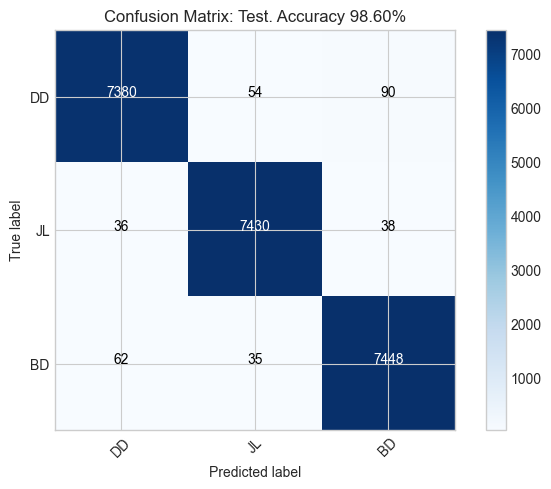

In [95]:
# Prediksi dan evaluasi menggunakan data uji asli
test_predictions_normalization = MLP_model_normalozation.predict(
    x=test_data_normalization, # Data uji asli yang sudah di-reshape
    batch_size=1, # Anda bisa sesuaikan batch_size untuk prediksi
    verbose=2
)
rounded_predictions_normalization = np.argmax(test_predictions_normalization, axis=-1)

cm_plot_labels = ['DD', 'JL', 'BD']
cm = confusion_matrix(y_true=test_label_normalization, y_pred=rounded_predictions_normalization)
accuracy = accuracy_score(test_label_normalization, rounded_predictions_normalization) * 100
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, 
                      # title=f'Confusion Matrix Test'
                      title=f'Confusion Matrix: Test. Accuracy {accuracy:.02f}%'
                      )
print("Per class: ", cm.diagonal()/cm.sum(axis=1))


# Mencetak classification report
report = classification_report(test_label_normalization, rounded_predictions_normalization, target_names=cm_plot_labels)
print(report)

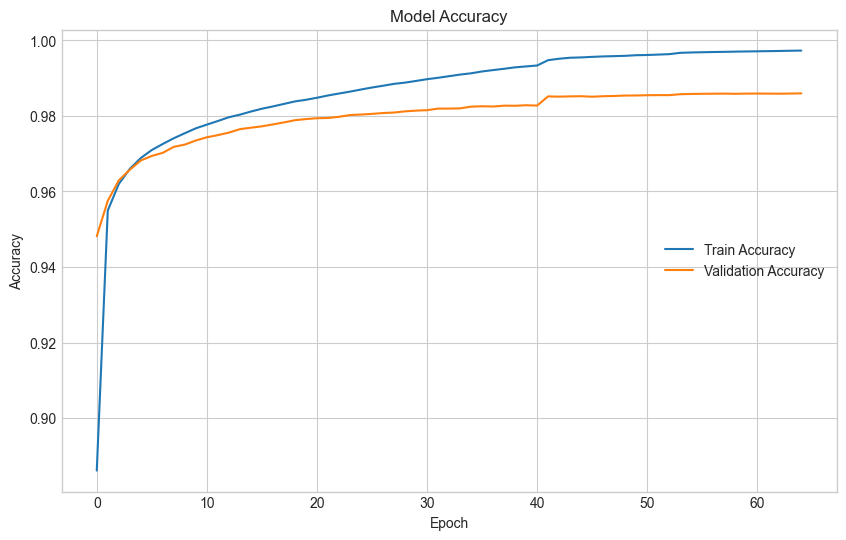

In [96]:
# Untuk plot history
train_accuracy = MLP_Robust_History.history['accuracy'] # Biasanya 'accuracy' bukan 'loss' untuk plot akurasi
val_accuracy = MLP_Robust_History.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy') # Ganti label 'test' menjadi 'validation'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='center right') # Sesuaikan lokasi legenda jika perlu
plt.show() # Tambahkan plt.show() untuk menampilkan plot

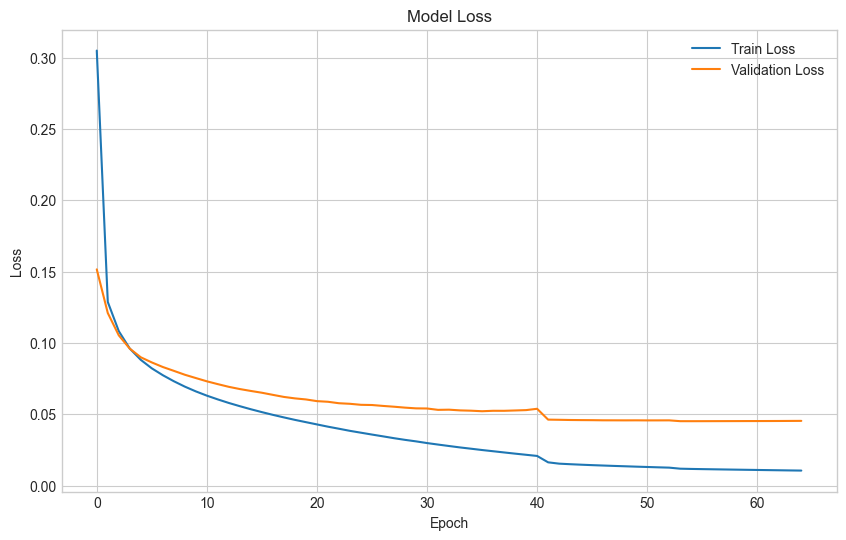

In [97]:
train_loss = MLP_Robust_History.history['loss']
val_loss = MLP_Robust_History.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss') # Ganti label 'test' menjadi 'validation'
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right') # Sesuaikan lokasi legenda jika perlu
plt.show() # Tambahkan plt.show() untuk menampilkan plot